# Creation of Multiple Models
This is the notebook used to train the Vocal Pitch Modulator.

We have four different architectures, and n neural networks per architecture, where n is the number of pitch shift values. The Four architectures that are trained are as follows:

0. Mel spectrum -> Decoded Mel Spectrum
1. MFCC + Chipmunked Mel spectrum -> Decoded Mel spectrum  
2. [MFCC -> Timbre Latent Variables] + Chipmunked Mel spectrum -> Decoded Mel spectrum  
3. Mel spectrum + Chipmunked Mel spectrum -> Decoded Mel spectrum  

To try the pitch shifter, just run the first cell and the last cell.

## Global variables/Imports
Run these cells before running either of the following sections.

In [9]:
%load_ext autoreload
%autoreload 1

import os
import csv

import scipy.io as sio
from scipy.io import wavfile
from scipy.io.wavfile import write

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import time
import math

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

from tqdm.notebook import trange, tqdm

from IPython.display import HTML
import warnings
from sklearn.preprocessing import OneHotEncoder

import torch
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

%aimport VPM
from VPM import *
%aimport Utils
from Utils import *
%aimport ANN
from ANN import *
%aimport PitchShifterModule
from PitchShifterModule import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Constants that should not change without the dataset being changed
n_pitches = 16
n_vowels = 12
n_people = 3

# These dictionaries are more for reference than anything
label_to_vowel = { 0: "bed",  1: "bird",   2: "boat",  3: "book", 
                   4: "cat",  5: "dog",    6: "feet",  7: "law",  
                   8: "moo",  9: "nut",   10: "pig",  11: "say" }

vowel_to_label = { "bed": 0,  "bird": 1,  "boat":  2, "book":  3,
                   "cat": 4,  "dog":  5,  "feet":  6, "law":   7,
                   "moo": 8,  "nut":  9,  "pig":  10, "say":  11}

noteidx_to_pitch = {  0: "A2",   1: "Bb2",  2: "B2",   3: "C3",
                      4: "Db3",  5: "D3",   6: "Eb3",  7: "E3", 
                      8: "F3",   9: "Gb3", 10: "G3",  11: "Ab3",
                     12: "A3",  13: "Bb3", 14: "B3",  15: "C4" }

### Constants
Used in this the data generation and ANN.

In [11]:
n_ffts = 2048
n_mels = 256
n_mfcc = 40
n_timb_hid = 36; n_timb = 10
TE_path = os.path.join('model_data', 'TimbreEncoder', 'TimbreVAE-IdealFixedNorm-40-36-10.pt')

### Data Generation
This is all the code that was explained in the Data Walkthrough. It generates data structures to hold all wav file data, spectrograms, mel spectra and MFCC data for all wav files.

For diagram-visualization of the data set, refer to the [readme](https://github.com/zioul123/VocalPitchModulator/blob/master/README.md).

The first cell involves 3d arrays, while the second cell involves flattened arrays.

In [12]:
# File reference lists
data_ref_list = create_data_ref_list(os.path.join("Data", 'dataset_files.csv'),
                            n_pitches, n_vowels, n_people)
# flat_data_ref_list[flat_ref_idx(vowel, pitch, person)]
flat_data_ref_list = flatten_3d_array(data_ref_list, 
                                      n_vowels, n_pitches, n_people)

# File reference list accessors
# Returns a flat_ref_idx, given a vowel, pitch, person
flat_ref_idx = lambda vowel, pitch, person: flat_3d_array_idx(
    vowel, pitch, person, n_vowels, n_pitches, n_people)
# Returns vowel, pitch, person, given a flat_ref_idx
nd_ref_idx = lambda idx: nd_array_idx(idx, n_vowels, n_pitches, n_people)

# Data-label pairs for pitch-shift training
data_label_pairs_flat, data_label_pairs_dict = create_data_label_pairs(n_pitches)

In [13]:
# wav, spectrogram, mels, mfcc for each file in flat_data_ref_list. n_windows is 115 with 75% overlap.
all_wav_data = load_wav_files(os.path.join("Data", "dataset"), flat_data_ref_list)
all_spectrograms = np.array([ stft(waveform, win_length=n_ffts, overlap=.5, plot=False) 
                              for waveform in all_wav_data ])

all_mels, all_mfcc = map(np.array, map(list, zip(*
                         [ ffts_to_mel(ffts, n_mels = n_mels, n_mfcc = n_mfcc) 
                           for ffts in all_spectrograms ])))

n_files, _, n_windows = all_mfcc.shape

print("all_wav_data shape = " , all_wav_data.shape)
print("all_spectrograms shape = ", all_spectrograms.shape)
print("all_mels shape = ", all_mels.shape)
print("all_mfcc shape = ", all_mfcc.shape)

all_wav_data shape =  (576,)
all_spectrograms shape =  (576, 1025, 29)
all_mels shape =  (576, 256, 29)
all_mfcc shape =  (576, 40, 29)


### Data-Label Structuring
This puts together the actual data-label pairs to be fed into the ANN.


In [14]:
# Flatten data

# Create data accessor for flat arrays
flat_data_idx = lambda wav_idx, win_idx: flat_2d_array_idx(
    wav_idx, win_idx, n_files, n_windows)

# Create flat mel spectra 
# flat_mels: (16704, 256)
flat_mels_prenorm = np.array([ all_mels[wav_file_idx][:, window_idx] 
                               for wav_file_idx in range(n_files) 
                               for window_idx in range(n_windows) ])
# Globally normalize to [-1, 1]
flat_mels_logged = np.log(flat_mels_prenorm)
max_mels = np.max(np.abs(flat_mels_logged))
flat_mels = flat_mels_logged / max_mels
print(flat_mels.shape)

# Create flat mfccs
# flat_mfcc: (16704, 12)
flat_mfcc_prenorm = np.array([ all_mfcc[wav_file_idx][:, window_idx]
                               for wav_file_idx in range(n_files)
                               for window_idx in range(n_windows) ])
# Globally normalize to [-1, 1]
flat_mfcc_logged = np.log(np.abs(flat_mfcc_prenorm))
max_mfcc = np.max(np.abs(flat_mfcc_logged))
flat_mfcc = flat_mfcc_logged / max_mfcc
print(flat_mfcc.shape)

# Create timbre features by calling TE encoding on mfccs
# Load the timbre encoder
TE = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_timb_hid, n_timb=n_timb)
TE.load_state_dict(torch.load(TE_path, map_location=torch.device('cpu')))
TE.eval()
# Call the timbre VAE's encode 
# flat_timbre: (16704, 6)
flat_mfcc_tensor = torch.Tensor(flat_mfcc)
flat_timbre_prenorm = TE.get_z(flat_mfcc_tensor).detach().numpy()
max_timbre = np.max(np.abs(flat_timbre_prenorm))
flat_timbre = flat_timbre_prenorm / max_timbre
print(flat_timbre.shape)

(16704, 256)
(16704, 40)
(16704, 10)


Visualization in plot

Text(0.5, 1.0, 'Timbre: (16704, 10)')

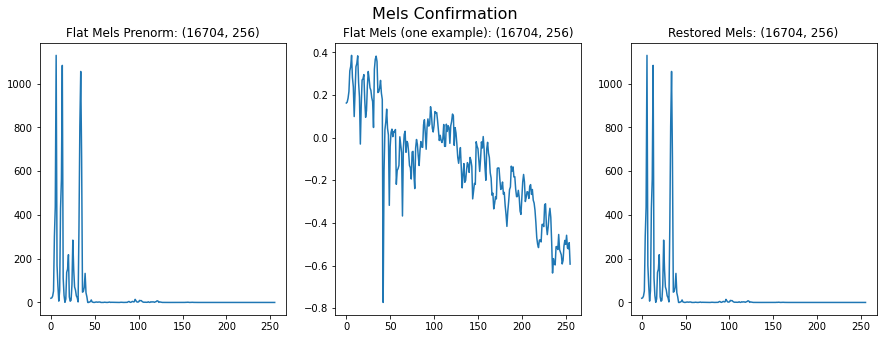

<Figure size 432x288 with 0 Axes>

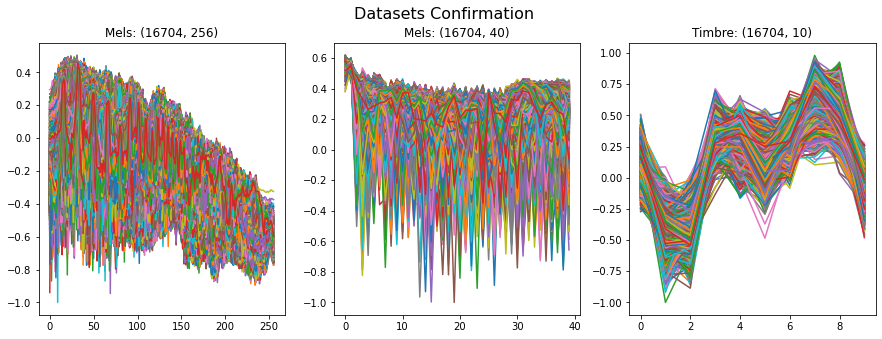

<Figure size 432x288 with 0 Axes>

In [20]:
# Visualize and verify Mels
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plt.figure()
fig.suptitle("Mels Reconstruction Confirmation", fontsize=16)
ax[0].plot(flat_mels_prenorm[0])
ax[0].set_title("Flat Mels Prenorm: {}".format(flat_mels_prenorm.shape))
ax[1].plot(flat_mels[0])
ax[1].set_title("Flat Mels (one example): {}".format(flat_mels.shape))
ax[2].plot(np.e ** (flat_mels[0] * max_mels))
ax[2].set_title("Restored Mels: {}".format(flat_mels.shape))

# Visualize and verify Mels
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plt.figure()
fig.suptitle("Datasets Confirmation", fontsize=16)
ax[0].plot(flat_mels.T)
ax[0].set_title("Mels: {}".format(flat_mels.shape))
ax[1].plot(flat_mfcc.T)
ax[1].set_title("Mels: {}".format(flat_mfcc.shape))
ax[2].plot(flat_timbre.T)
ax[2].set_title("Timbre: {}".format(flat_timbre.shape))

## Pre-Training - Autoencoder stage

### Data-Label Structuring
This puts together the actual data-label pairs to be fed into the ANN.

`data` is generated from timbre features on mfcc and mel spectrums. `labels` are abs(fft) spectrograms. At this stage, pre-training, we simply want to make the NN learn to output mel spectra, so they are trained with identity - the input mel spectra and label mel spectra are identical.

In [15]:
# Create data/labels for different architectures.
# Mode 0 - spectrum -> Decoded Mel Spectrum
# Mode 1 -  MFCC + Chipmunked Mel spectrum -> Decoded Mel spectrum  
# Mode 2 -  [MFCC -> Timbre Latent Variables] + Chipmunked Mel spectrum -> Decoded Mel spectrum  
# Mode 3 -  Mel spectrum + Chipmunked Mel spectrum -> Decoded Mel spectrum  
def createData(mode):
    labels = flat_mels
    if (mode == 0):
        data = flat_mels
    if (mode == 1):
        data = np.concatenate((flat_mfcc, flat_mels), axis=1)
    if (mode == 2):
        data = np.concatenate((flat_timbre, flat_mels), axis=1)   
    if (mode == 3):
        data = np.concatenate((flat_mels, flat_mels), axis=1)   
    print(data.shape, labels.shape)

    # X_train, Y_train: (11136, 296) (11136, 256) 
    # X_val, Y_val:     (5568, 296)  (5568, 256)
    X_train = []; X_val = []; Y_train = []; Y_val = []
    for vow_idx in range(n_vowels):
        for pit_idx in range(n_pitches):
            # Choose the person for this pitch/vowel to be used as test data
            test_pid = int(np.random.rand() * 3)
            for pid_idx in range(n_people):
                wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
                if (pid_idx != test_pid):
                    for win_idx in range(n_windows):
                        X_train.append(data[flat_data_idx(wav_idx, win_idx)])
                        Y_train.append(labels[flat_data_idx(wav_idx, win_idx)])
                else:
                    for win_idx in range(n_windows):
                        X_val.append(data[flat_data_idx(wav_idx, win_idx)])
                        Y_val.append(labels[flat_data_idx(wav_idx, win_idx)])  
    X_train, Y_train, X_val, Y_val = map(torch.Tensor, (X_train, Y_train, X_val, Y_val))

    # Default tensor is float
    X_train = X_train.float(); X_val = X_val.float()
    Y_train = Y_train.float(); Y_val = Y_val.float()
    print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)
    
    return data, labels, X_train, Y_train, X_val, Y_val

In [16]:
datas, labelss, X_trains, Y_trains, X_vals, Y_vals = zip(*[ createData(archi) for archi in range(4) ])

(16704, 256) (16704, 256)
torch.Size([11136, 256]) torch.Size([5568, 256]) torch.Size([11136, 256]) torch.Size([5568, 256])
(16704, 296) (16704, 256)
torch.Size([11136, 296]) torch.Size([5568, 296]) torch.Size([11136, 256]) torch.Size([5568, 256])
(16704, 266) (16704, 256)
torch.Size([11136, 266]) torch.Size([5568, 266]) torch.Size([11136, 256]) torch.Size([5568, 256])
(16704, 512) (16704, 256)
torch.Size([11136, 512]) torch.Size([5568, 512]) torch.Size([11136, 256]) torch.Size([5568, 256])


### Training Procedure (decoder style, no pitch shift)

Try to recreate the original spectra given the dataset.

In [50]:
n_inputs = [ 256, 296, 266, 512 ] 
n_hids =  [ 256, 296, 266, 512 ]
lr = 1e-3; n_epochs = 5000;
loss_fn = nn.MSELoss()

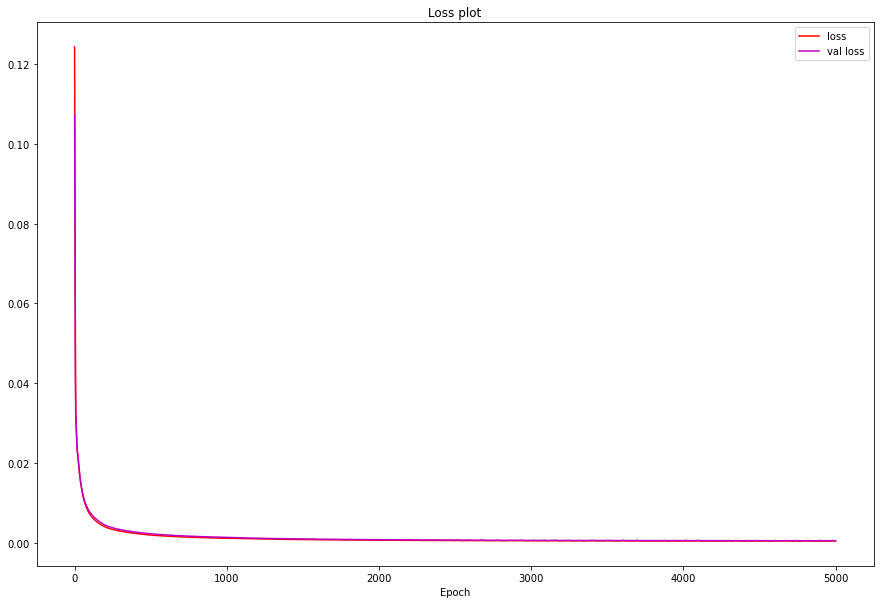

Training Loss before/after: 0.12433592230081558, 0.00040879493462853134
Validation Loss before/after: 0.1073455661535263, 0.0004891852731816471
Final loss for n_hid[256]: 0.00040879493462853134
Time taken: 33.272380113601685
Model saved at model_data\VPMModel\Archi-0_Identity-Mels-to-Mels_epoch5000_256_256_256.pt


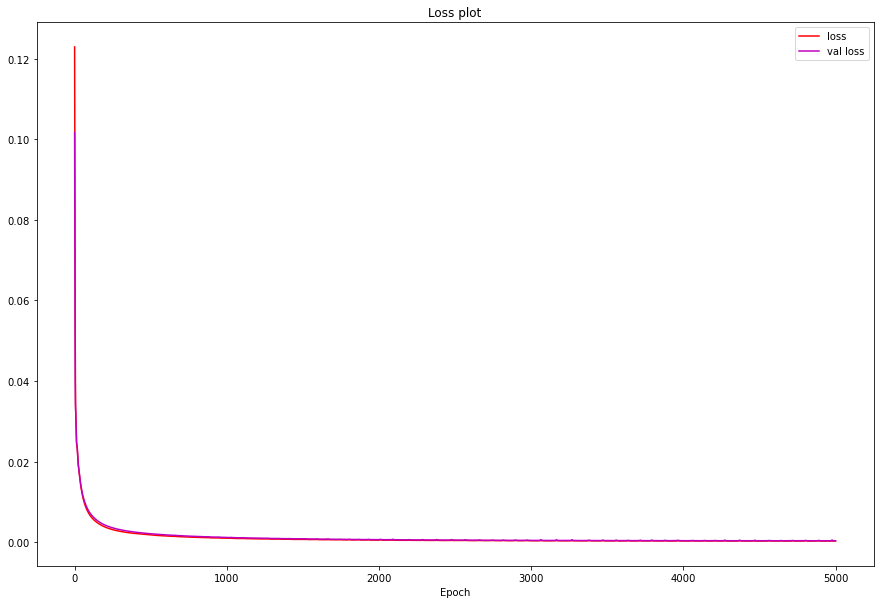

Training Loss before/after: 0.12291842699050903, 0.00029837447800673544
Validation Loss before/after: 0.10169138759374619, 0.0003765530127566308
Final loss for n_hid[296]: 0.00029837447800673544
Time taken: 35.909464836120605
Model saved at model_data\VPMModel\Archi-1_Identity-Mels-to-Mels_epoch5000_296_296_256.pt


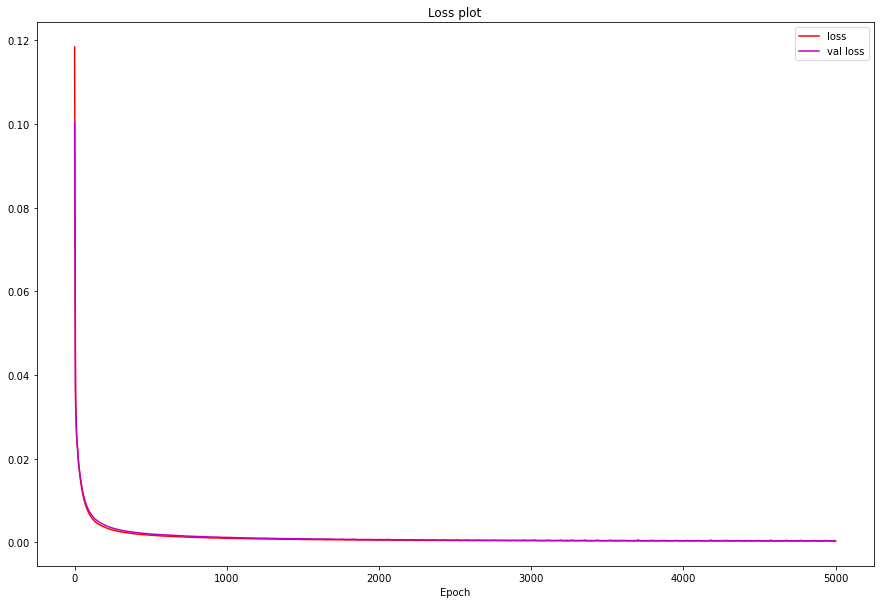

Training Loss before/after: 0.11840653419494629, 0.0002701583434827626
Validation Loss before/after: 0.10025572776794434, 0.00034117416362278163
Final loss for n_hid[266]: 0.0002701583434827626
Time taken: 46.58932876586914
Model saved at model_data\VPMModel\Archi-2_Identity-Mels-to-Mels_epoch5000_266_266_256.pt


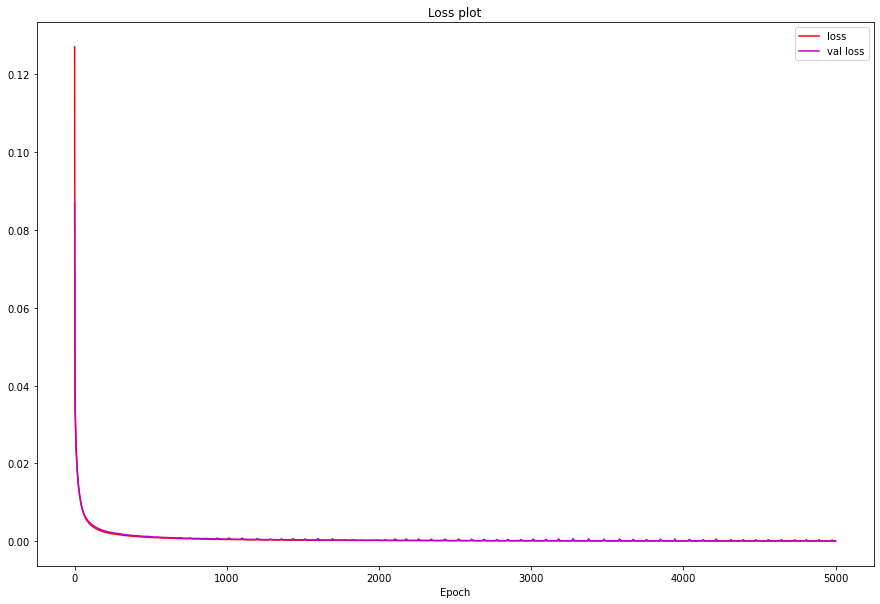

Training Loss before/after: 0.1268966645002365, 9.465414768783376e-05
Validation Loss before/after: 0.08700226247310638, 0.0001237101823789999
Final loss for n_hid[512]: 9.465414768783376e-05
Time taken: 53.4590322971344
Model saved at model_data\VPMModel\Archi-3_Identity-Mels-to-Mels_epoch5000_512_512_256.pt


In [53]:
# Use GPU if possible (will run on CPU otherwise)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Train all three architectures
for archi in range(4):
    # Move inputs to GPU (if possible)
    X_train = X_trains[archi].to(device)
    Y_train = Y_trains[archi].to(device)
    X_val = X_vals[archi].to(device)
    Y_val = Y_vals[archi].to(device)

    # Training model 
    model = TimbreFNN(n_input=n_inputs[archi], n_hid=n_hids[archi], n_output=n_mels)

    # Move the network to GPU (if possible)
    model.to(device)

    # Define optimizer 
    # opt = optim.SGD(model.parameters(), lr=lr)
    opt = optim.Adam(model.parameters(), lr=lr)

    # Fit the model
    tic = time.time()
    train_loss, val_loss = model.train_func(X_train, Y_train, X_val, Y_val, model, opt,
                            loss_fn, epochs=n_epochs, print_graph=True)
    toc = time.time()
    print('Final loss for n_hid[{}]: {}\nTime taken: {}'.format(n_hids[archi], train_loss, toc - tic))

    model_path = os.path.join("model_data", "VPMModel", "Archi-{}_Identity-Mels-to-Mels_epoch{}_{}_{}_{}.pt"
                              .format(archi, n_epochs, n_inputs[archi], n_hids[archi], n_mels))
    torch.save(model.state_dict(), model_path)
    print("Model saved at {}".format(model_path))


Saving the model

Loading the saved model, and using the model for prediction example

In [ ]:
vidx = 4; pIdx = 3; pid = 0; winIdx = 20;
wavIdx = flat_ref_idx(vidx, pIdx, pid)

model_paths = [
    "Archi-0_Identity-Mels-to-Mels_epoch5000_256_256_256.pt",
    "Archi-1_Identity-Mels-to-Mels_epoch5000_296_296_256.pt",
    "Archi-2_Identity-Mels-to-Mels_epoch5000_266_266_256.pt",
    "Archi-3_Identity-Mels-to-Mels_epoch5000_512_512_256.pt"
]
n_inputs = [ 256, 296, 266, 512 ] 
n_hids =  [ 256, 296, 266, 512 ]

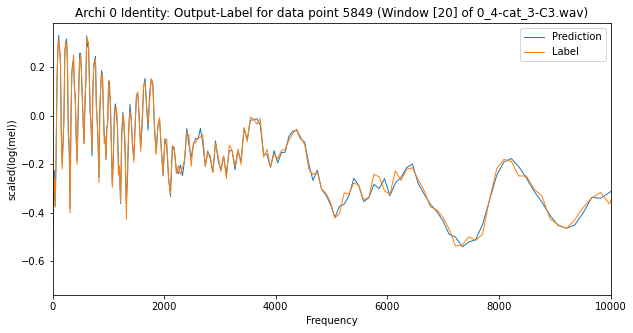

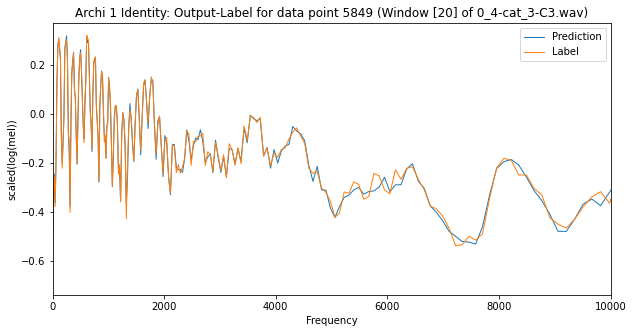

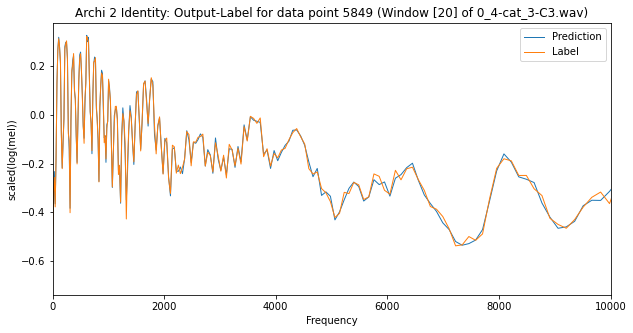

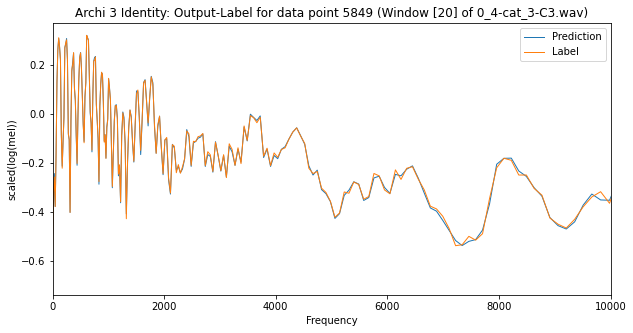

In [22]:
# Plot a single window spectrum sample
for archi in range(4):
    model = BaseFFN(n_input=n_inputs[archi], n_hid=n_hids[archi], n_output=n_mels)
    model.load_state_dict(torch.load(os.path.join("model_data", "VPMModel", model_paths[archi]), map_location=torch.device('cpu')))
    model.eval()

    data_tensor, label_tensor = map(torch.tensor, (datas[archi], labelss[archi]))
    data_tensor = data_tensor.float(); label_tensor = label_tensor.float(); 
    predictions = model(data_tensor).detach().numpy()

    # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    # Graphing of a single mel spectra for one datapoint  #
    # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    data_point = flat_data_idx(wavIdx, winIdx)
    x_axis = librosa.core.mel_frequencies(n_mels=256, fmin=0.0, fmax=22050.0)
    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, predictions[data_point], label='Prediction', linewidth=1)
    plt.plot(x_axis, label_tensor[data_point], label='Label', linewidth=1)
    plt.xlim(0, 10000)
    plt.xlabel('Frequency')
    plt.ylabel('scaled(log(mel))')
    plt.legend(loc='best')
    plt.title("Archi {} Identity: Output-Label for data point {} (Window [{}] of {})".format(archi, data_point, winIdx, flat_data_ref_list[wavIdx]))
    plt.savefig(os.path.join("model_data", "VPMModel", "Archi-{}_SampleOutput_".format(archi) + model_paths[archi] + '.png')) 

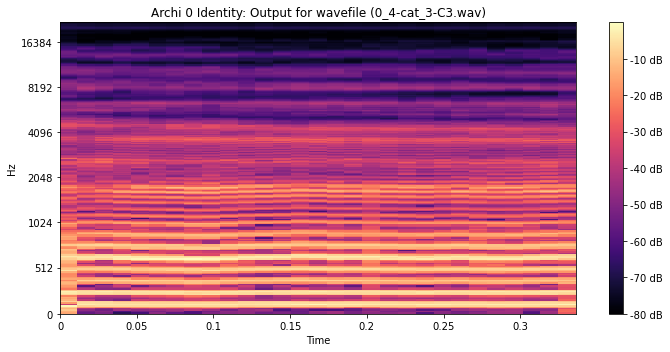

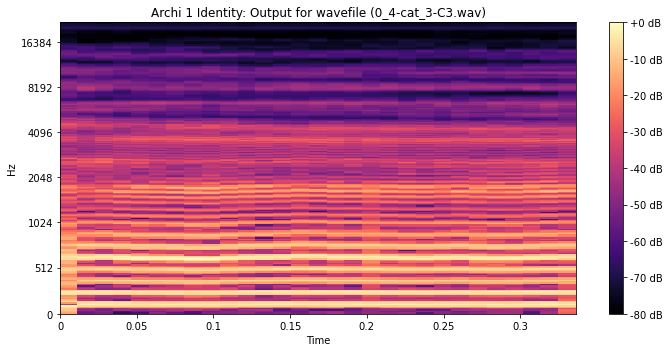

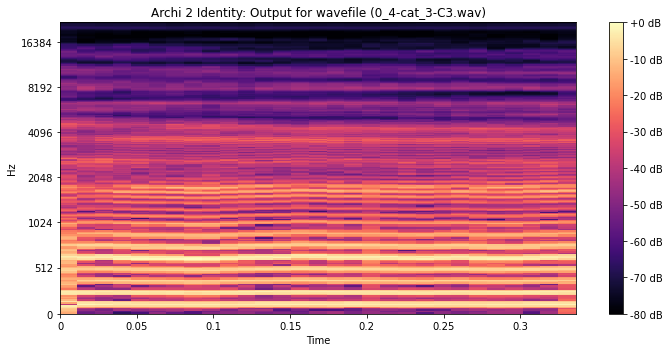

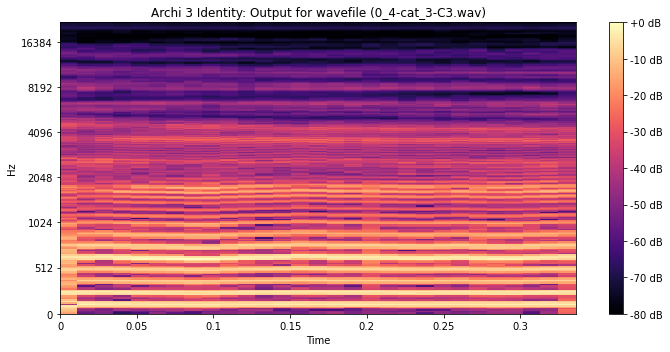

In [26]:
# Plot a full spectrogram
for archi in range(4):
    model = BaseFFN(n_input=n_inputs[archi], n_hid=n_hids[archi], n_output=n_mels)
    model.load_state_dict(torch.load(os.path.join("model_data", "VPMModel", model_paths[archi]), map_location=torch.device('cpu')))
    model.eval()

    data_tensor, label_tensor = map(torch.tensor, (datas[archi], labelss[archi]))
    data_tensor = data_tensor.float(); label_tensor = label_tensor.float(); 
    predictions = model(data_tensor).detach().numpy()

    # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    # Graphing of a single mel spectra for one datapoint  #
    # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    data_pointStrt = flat_data_idx(wavIdx, 0)
    data_pointExcl = flat_data_idx(wavIdx+1, 0)
    
    melSpectrum = predictions[data_pointStrt:data_pointExcl].T
    melSpectrum = np.e ** (melSpectrum * max_mels)
    
    plt.figure(figsize=(10, 5))
    S_dB = librosa.power_to_db(melSpectrum, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=44100, fmax=44100/2.0)
    plt.colorbar(format='%+2.0f dB')
    plt.title("Archi {} Identity: Output for wavefile ({})".format(archi, flat_data_ref_list[wavIdx]))
    plt.tight_layout()
    # Does not work - manually rename the images saved
    plt.savefig(os.path.join("model_data", "VPMModel", "Archi-{}_MelSpectra_".format(archi) + model_paths[archi] + '.png')) 
    plt.show()

## Training - Waveform conformation for each individual pitch

### Data-Label Structuring Function
This puts together the actual data-label pairs to be fed into the ANN.

`data` is generated from mel spectrums. `labels` are mel spectrograms. At this stage, we want the ANN to learn to conform pitch shifted mel spectra to the correct form.

In [66]:
# Create data/labels for different architectures.
# Mode 0 - spectrum -> Decoded Mel Spectrum
# Mode 1 -  MFCC + Chipmunked Mel spectrum -> Decoded Mel spectrum  
# Mode 2 -  [MFCC -> Timbre Latent Variables] + Chipmunked Mel spectrum -> Decoded Mel spectrum  
# Mode 3 -  Mel spectrum + Chipmunked Mel spectrum -> Decoded Mel spectrum 
def create_training_dataset(n_ffts, overlap, n_mels,
                            shift_amt, sparsity_factor = 8):
    print('Creating dataset for shift_amt = {}'.format(shift_amt))
    
    # Initialize shift_amt dependent data structures
    pairs = data_label_pairs_dict[shift_amt]
    # all_pitched_spectra: (576, 1025, 29)
    _, all_pitched_spectra = resample_pitch_shift(all_wav_data, shift_amt, overlap, n_ffts=n_ffts)
    # all_mels: (576, 256, 29)
    all_pitched_mels_prenorm = np.array([ ffts_to_mel(ffts, n_mels = n_mels, skip_mfcc=True) 
                                          for ffts in all_pitched_spectra ])
    all_pitched_mels_prenorm_logged = np.log(all_pitched_mels_prenorm)
    max_pitched_mels = np.max(np.abs(all_pitched_mels_prenorm_logged))
    all_pitched_mels = all_pitched_mels_prenorm_logged / max_pitched_mels   
    X_trains = [[], [], [], []]
    X_vals = [[], [], [], []]; 
    Y_trains = [[], [], [], []]; 
    Y_vals = [[], [], [], []];
    list_of_test_idx = [[], [], [], []]
    for vow_idx in range(n_vowels):
        for pit_idx in range(n_pitches):
            # If the pair is valid (does not go out of range), then proceed.
            if [shift_amt, pit_idx, pit_idx + shift_amt] in pairs:
                # Choose the person for this pitch/vowel to be used as test data.
                test_pid = int(np.random.rand() * 3)

                for pid_idx in range(n_people):
                    # Wav index
                    wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
                    wav_idx_shifted = flat_ref_idx(vow_idx, pit_idx + shift_amt, pid_idx)
                    # Window index lower-upper bounds
                    data_flat_start_idx = flat_data_idx(wav_idx, 0)
                    data_flat_end_idx = flat_data_idx(wav_idx + 1, 0)
                    label_flat_start_idx = flat_data_idx(wav_idx_shifted, 0)
                    label_flat_end_idx = flat_data_idx(wav_idx_shifted + 1, 0)
                    
                    # Create the datasets for each mode
                    for mode in range(4):
                        if (mode == 0):
                            x_item = flat_mels[data_flat_start_idx:data_flat_end_idx][0::sparsity_factor]
                        if (mode == 1):
                            x_item = np.hstack((flat_mfcc[data_flat_start_idx:data_flat_end_idx], 
                                                all_pitched_mels[wav_idx].T))[0::sparsity_factor]
                        if (mode == 2):
                            x_item = np.hstack((flat_timbre[data_flat_start_idx:data_flat_end_idx], 
                                                all_pitched_mels[wav_idx].T))[0::sparsity_factor]
                        if (mode == 3):
                            x_item = np.hstack((flat_mels[data_flat_start_idx:data_flat_end_idx], 
                                                all_pitched_mels[wav_idx].T))[0::sparsity_factor]
                        y_item = flat_mels[label_flat_start_idx:label_flat_end_idx][0::sparsity_factor]

                        if (pid_idx != test_pid):
                            X_trains[mode].extend(x_item)
                            Y_trains[mode].extend(y_item)
                        else:
                            X_vals[mode].extend(x_item)
                            Y_vals[mode].extend(y_item)
                            list_of_test_idx.append((wav_idx,wav_idx_shifted))
    for mode in range(4):
        X_trains[mode] = np.array(X_trains[mode]); Y_trains[mode] = np.array(Y_trains[mode]);
        X_vals[mode] = np.array(X_vals[mode]); Y_vals[mode] = np.array(Y_vals[mode]);
        print("Archi {}: X_train: {}, Y_train: {}, X_val: {}, Y_val: {}".format(mode, X_trains[mode].shape, Y_trains[mode].shape, X_vals[mode].shape, Y_vals[mode].shape))

    list_of_test_idx = np.array(list_of_test_idx)
    return X_trains, Y_trains, X_vals, Y_vals, list_of_test_idx, max_pitched_mels, all_pitched_mels

## Training Pitch-shift specific models
Train 11 different NNs - one for each pitch shift.

0. Shift amt -5
Creating dataset for shift_amt = -5
Archi 0: X_train: (2112, 256), Y_train: (2112, 256), X_val: (1056, 256), Y_val: (1056, 256)
Archi 1: X_train: (2112, 296), Y_train: (2112, 256), X_val: (1056, 296), Y_val: (1056, 256)
Archi 2: X_train: (2112, 266), Y_train: (2112, 256), X_val: (1056, 266), Y_val: (1056, 256)
Archi 3: X_train: (2112, 512), Y_train: (2112, 256), X_val: (1056, 512), Y_val: (1056, 256)


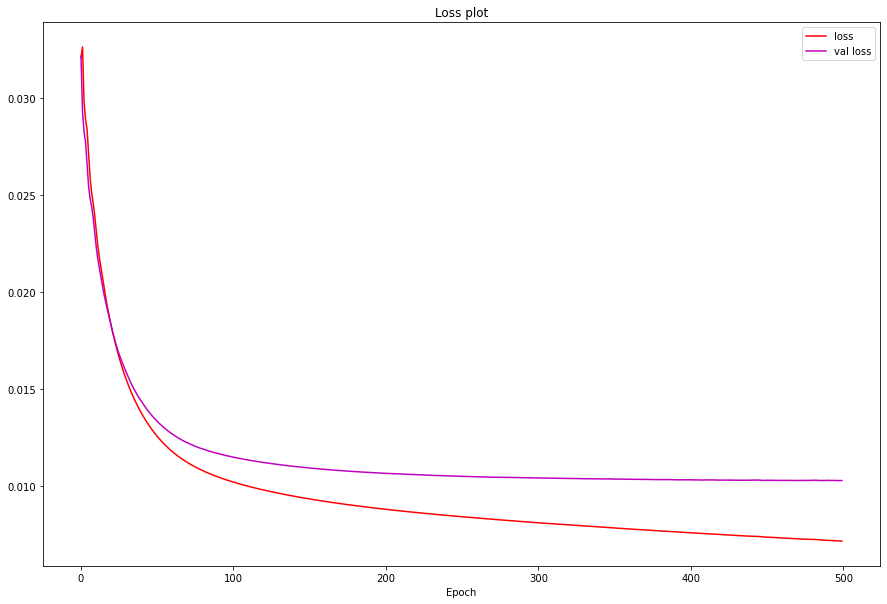

Training Loss before/after: 0.03207189589738846, 0.007163413800299168
Validation Loss before/after: 0.03211820498108864, 0.010278635658323765
Final loss: 0.007163413800299168
Time taken: 3.0389349460601807
Model saved at model_data\VPMModel\Archi-0_[-5]-_epoch500_256_256_256.pt


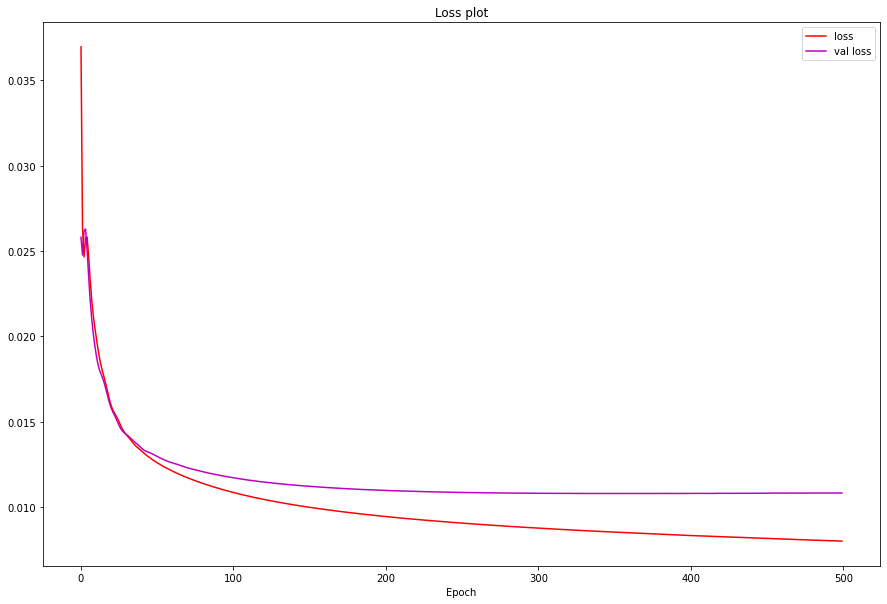

Training Loss before/after: 0.03693787753582001, 0.008030540309846401
Validation Loss before/after: 0.025803525000810623, 0.010841691866517067
Final loss: 0.008030540309846401
Time taken: 3.0808839797973633
Model saved at model_data\VPMModel\Archi-1_[-5]-_epoch500_296_296_256.pt


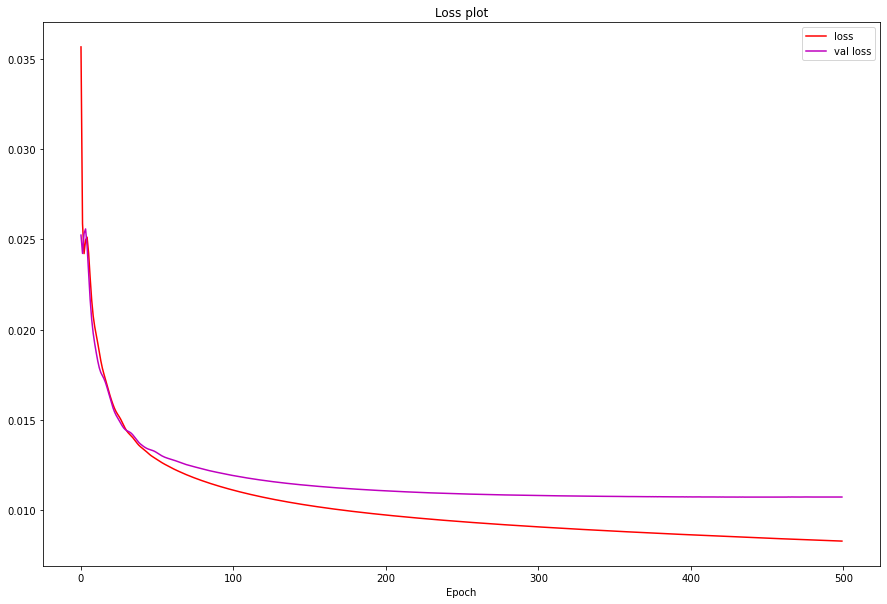

Training Loss before/after: 0.035658933222293854, 0.008294452913105488
Validation Loss before/after: 0.025237536057829857, 0.01073449570685625
Final loss: 0.008294452913105488
Time taken: 3.192411422729492
Model saved at model_data\VPMModel\Archi-2_[-5]-_epoch500_266_266_256.pt


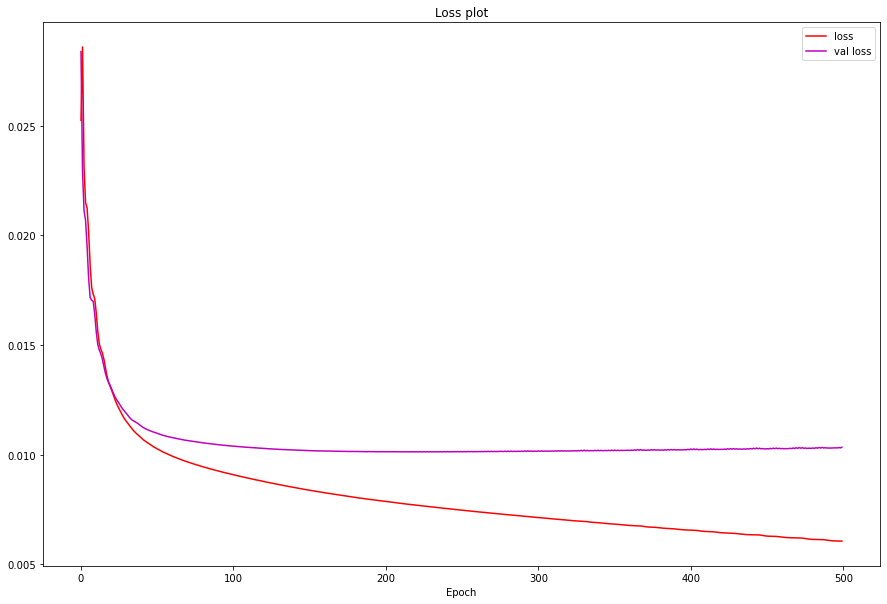

Training Loss before/after: 0.025252141058444977, 0.0060510411858558655
Validation Loss before/after: 0.02839084155857563, 0.01033650804311037
Final loss: 0.0060510411858558655
Time taken: 3.2496047019958496
Model saved at model_data\VPMModel\Archi-3_[-5]-_epoch500_512_512_256.pt
1. Shift amt -4
Creating dataset for shift_amt = -4
Archi 0: X_train: (2304, 256), Y_train: (2304, 256), X_val: (1152, 256), Y_val: (1152, 256)
Archi 1: X_train: (2304, 296), Y_train: (2304, 256), X_val: (1152, 296), Y_val: (1152, 256)
Archi 2: X_train: (2304, 266), Y_train: (2304, 256), X_val: (1152, 266), Y_val: (1152, 256)
Archi 3: X_train: (2304, 512), Y_train: (2304, 256), X_val: (1152, 512), Y_val: (1152, 256)


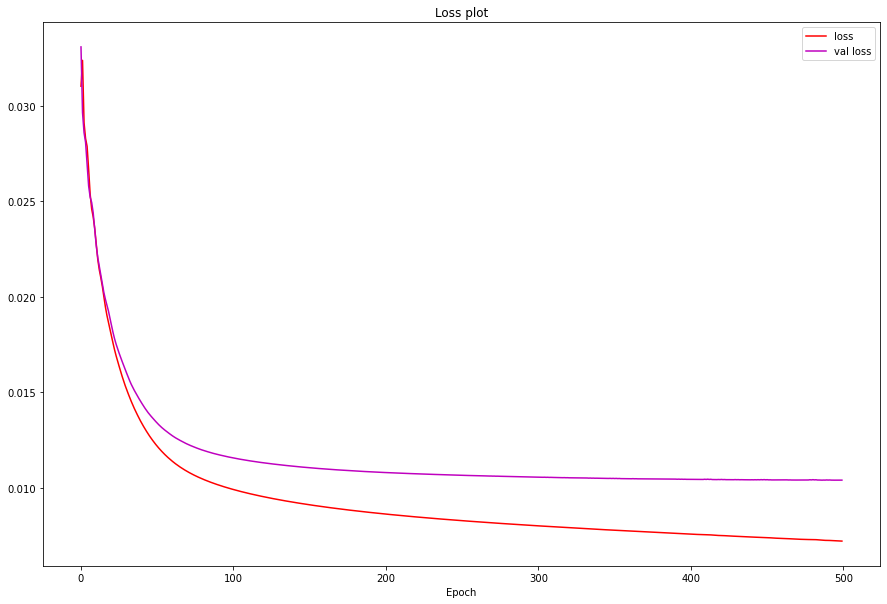

Training Loss before/after: 0.031015779823064804, 0.007195361889898777
Validation Loss before/after: 0.033074233680963516, 0.010387531481683254
Final loss: 0.007195361889898777
Time taken: 3.016141176223755
Model saved at model_data\VPMModel\Archi-0_[-4]-_epoch500_256_256_256.pt


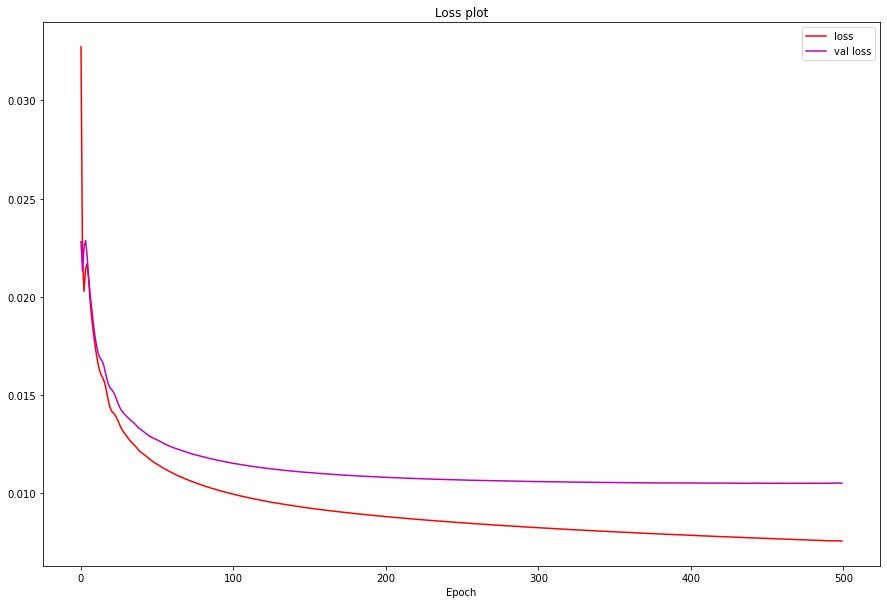

Training Loss before/after: 0.03272669389843941, 0.007568496745079756
Validation Loss before/after: 0.02281183749437332, 0.010512709617614746
Final loss: 0.007568496745079756
Time taken: 3.254075765609741
Model saved at model_data\VPMModel\Archi-1_[-4]-_epoch500_296_296_256.pt


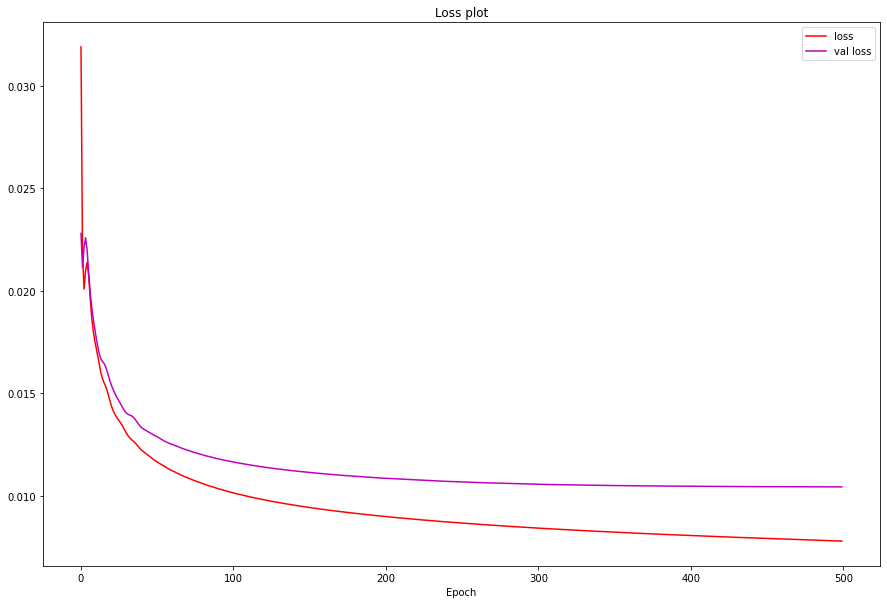

Training Loss before/after: 0.031895436346530914, 0.007802052889019251
Validation Loss before/after: 0.02280326746404171, 0.010445342399179935
Final loss: 0.007802052889019251
Time taken: 3.276759624481201
Model saved at model_data\VPMModel\Archi-2_[-4]-_epoch500_266_266_256.pt


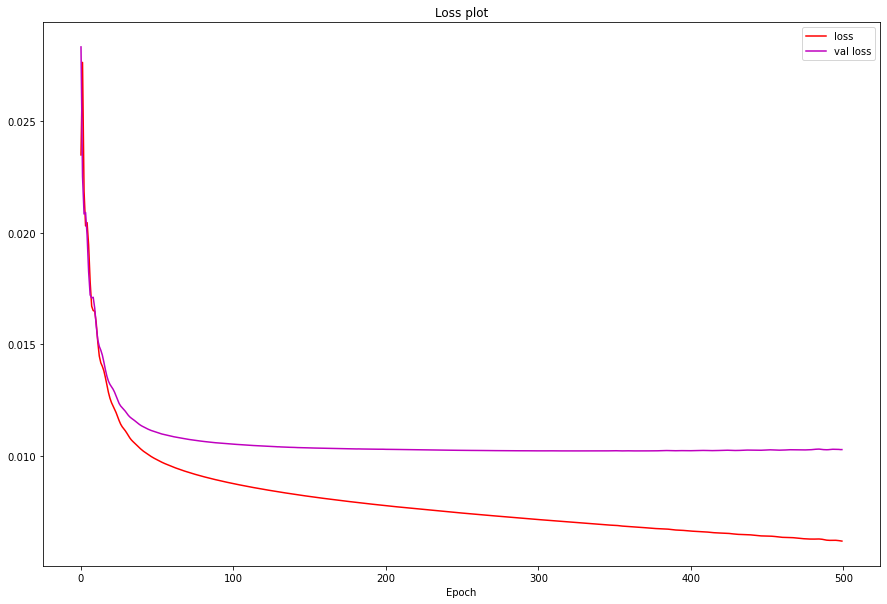

Training Loss before/after: 0.023475922644138336, 0.006189500913023949
Validation Loss before/after: 0.02831215411424637, 0.010286162607371807
Final loss: 0.006189500913023949
Time taken: 3.3440728187561035
Model saved at model_data\VPMModel\Archi-3_[-4]-_epoch500_512_512_256.pt
2. Shift amt -3
Creating dataset for shift_amt = -3
Archi 0: X_train: (2496, 256), Y_train: (2496, 256), X_val: (1248, 256), Y_val: (1248, 256)
Archi 1: X_train: (2496, 296), Y_train: (2496, 256), X_val: (1248, 296), Y_val: (1248, 256)
Archi 2: X_train: (2496, 266), Y_train: (2496, 256), X_val: (1248, 266), Y_val: (1248, 256)
Archi 3: X_train: (2496, 512), Y_train: (2496, 256), X_val: (1248, 512), Y_val: (1248, 256)


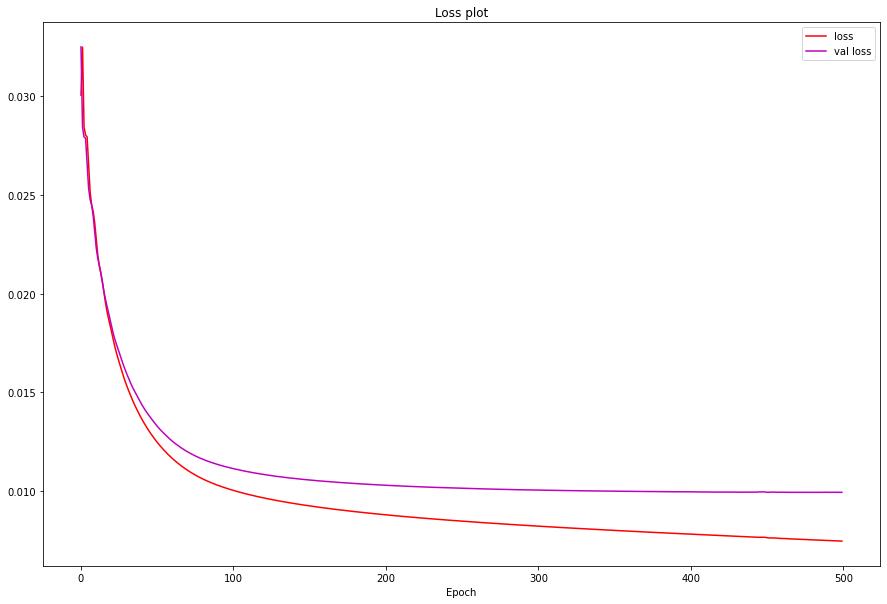

Training Loss before/after: 0.03006679005920887, 0.007456717547029257
Validation Loss before/after: 0.032511815428733826, 0.009929380379617214
Final loss: 0.007456717547029257
Time taken: 3.037273406982422
Model saved at model_data\VPMModel\Archi-0_[-3]-_epoch500_256_256_256.pt


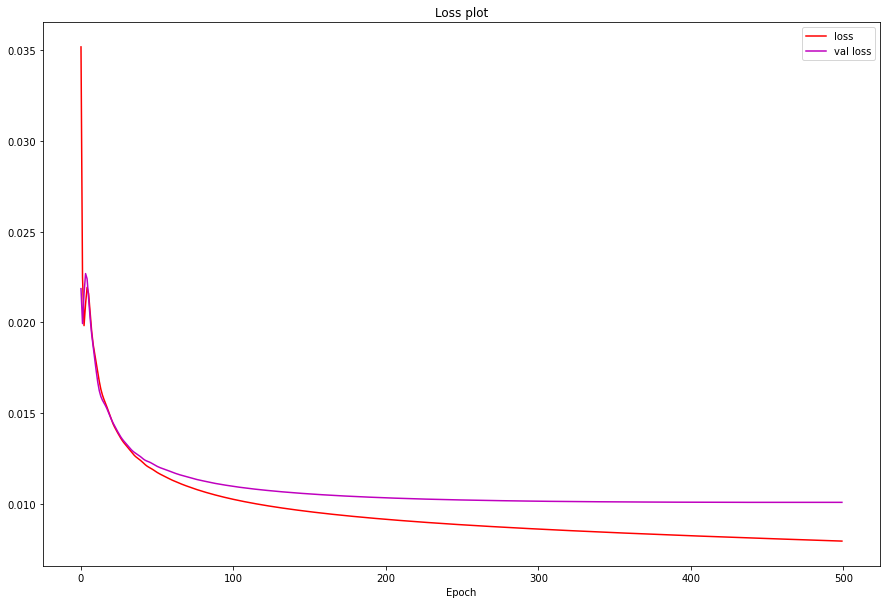

Training Loss before/after: 0.0351889505982399, 0.007928483188152313
Validation Loss before/after: 0.021853800863027573, 0.010065934620797634
Final loss: 0.007928483188152313
Time taken: 3.1677825450897217
Model saved at model_data\VPMModel\Archi-1_[-3]-_epoch500_296_296_256.pt


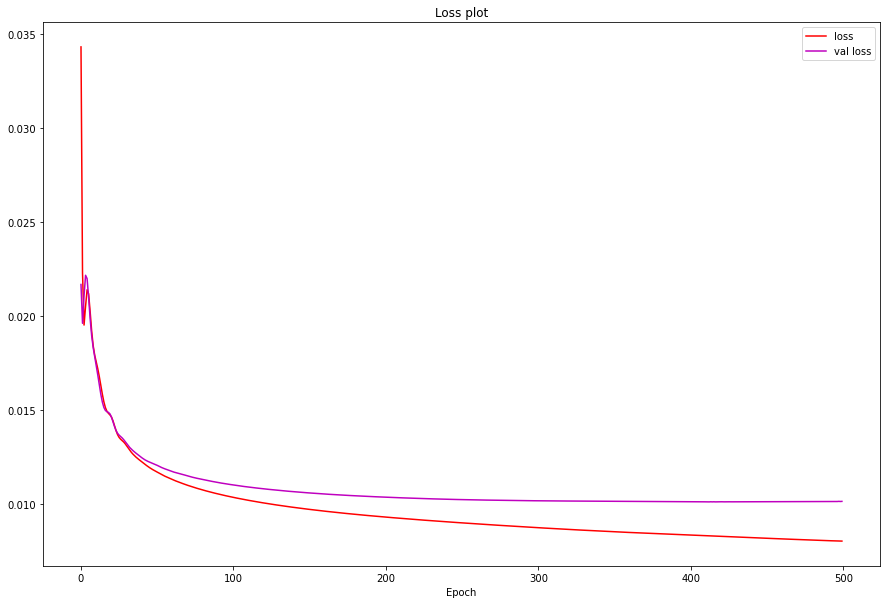

Training Loss before/after: 0.03433831408619881, 0.008016664534807205
Validation Loss before/after: 0.021684613078832626, 0.010132077150046825
Final loss: 0.008016664534807205
Time taken: 3.21256160736084
Model saved at model_data\VPMModel\Archi-2_[-3]-_epoch500_266_266_256.pt


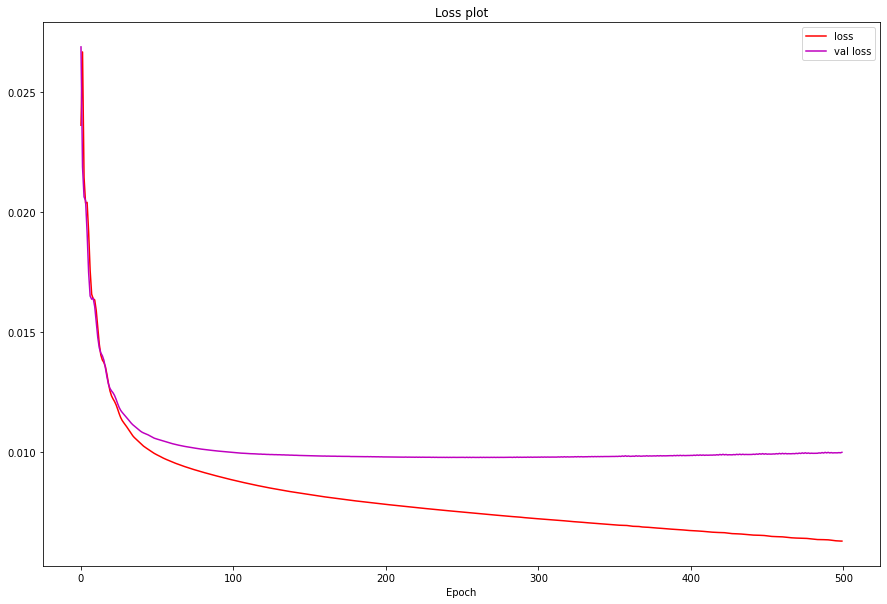

Training Loss before/after: 0.023610875010490417, 0.006289924029260874
Validation Loss before/after: 0.026874536648392677, 0.00998743437230587
Final loss: 0.006289924029260874
Time taken: 3.4937312602996826
Model saved at model_data\VPMModel\Archi-3_[-3]-_epoch500_512_512_256.pt
3. Shift amt -2
Creating dataset for shift_amt = -2
Archi 0: X_train: (2688, 256), Y_train: (2688, 256), X_val: (1344, 256), Y_val: (1344, 256)
Archi 1: X_train: (2688, 296), Y_train: (2688, 256), X_val: (1344, 296), Y_val: (1344, 256)
Archi 2: X_train: (2688, 266), Y_train: (2688, 256), X_val: (1344, 266), Y_val: (1344, 256)
Archi 3: X_train: (2688, 512), Y_train: (2688, 256), X_val: (1344, 512), Y_val: (1344, 256)


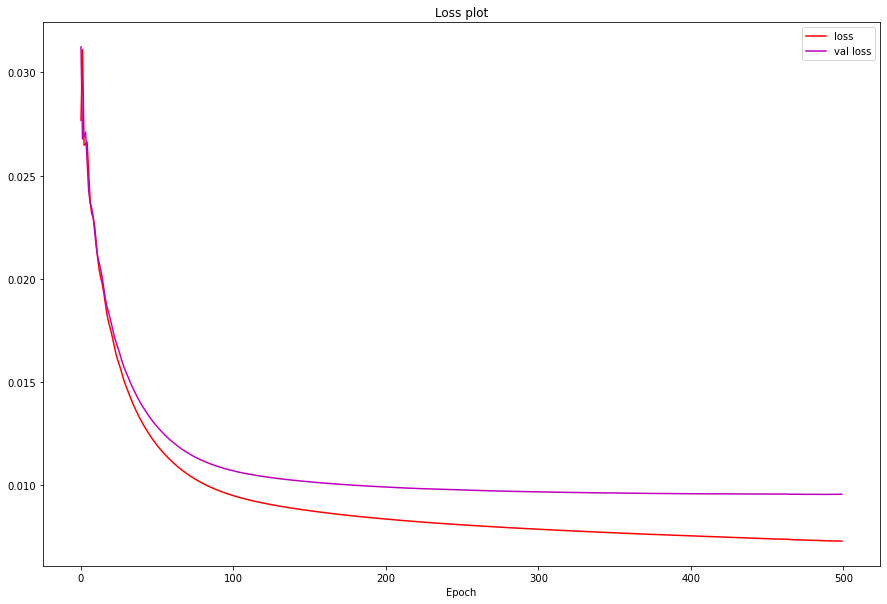

Training Loss before/after: 0.0276755690574646, 0.007291682064533234
Validation Loss before/after: 0.03123173862695694, 0.009561833925545216
Final loss: 0.007291682064533234
Time taken: 3.037459373474121
Model saved at model_data\VPMModel\Archi-0_[-2]-_epoch500_256_256_256.pt


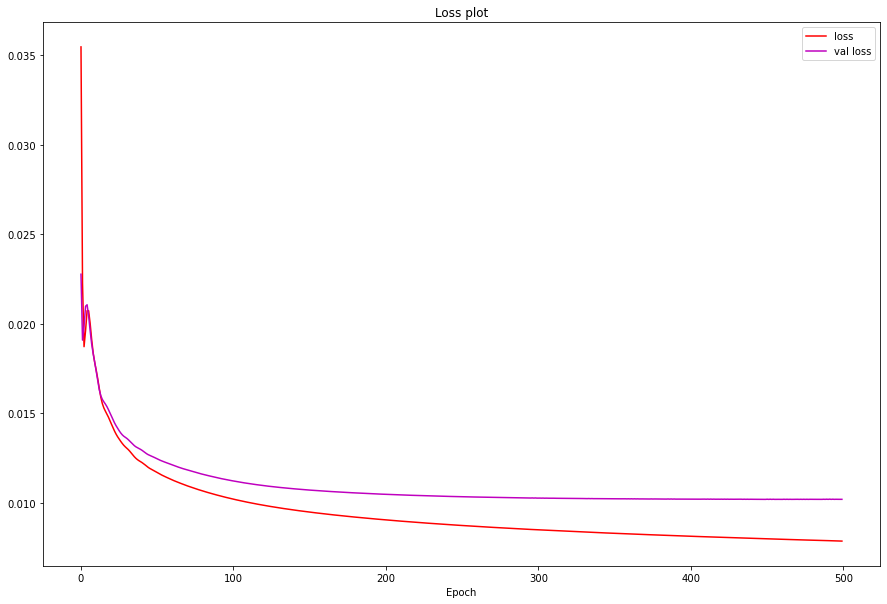

Training Loss before/after: 0.03546077758073807, 0.00784347951412201
Validation Loss before/after: 0.022756896913051605, 0.010177526623010635
Final loss: 0.00784347951412201
Time taken: 3.150015115737915
Model saved at model_data\VPMModel\Archi-1_[-2]-_epoch500_296_296_256.pt


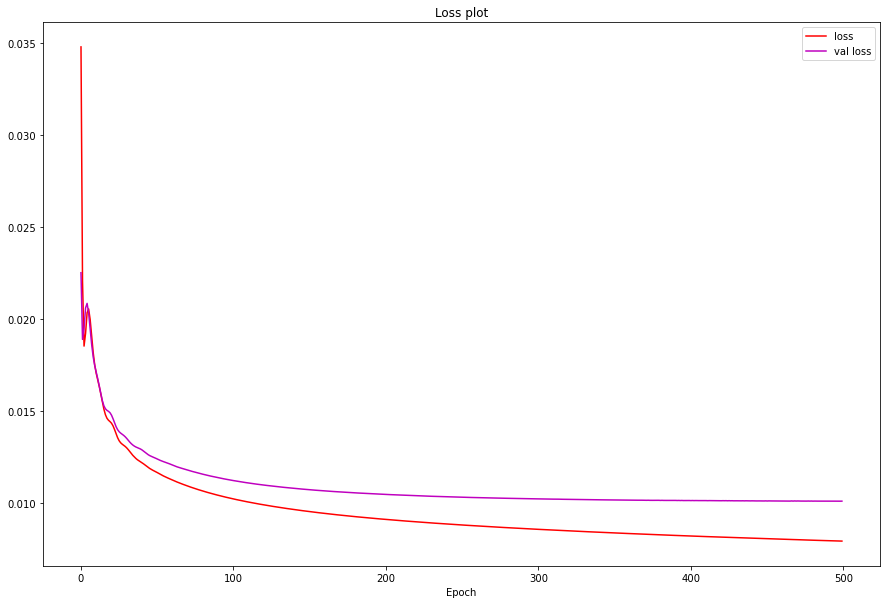

Training Loss before/after: 0.03481130301952362, 0.007933580316603184
Validation Loss before/after: 0.022530095651745796, 0.010106473229825497
Final loss: 0.007933580316603184
Time taken: 3.2428641319274902
Model saved at model_data\VPMModel\Archi-2_[-2]-_epoch500_266_266_256.pt


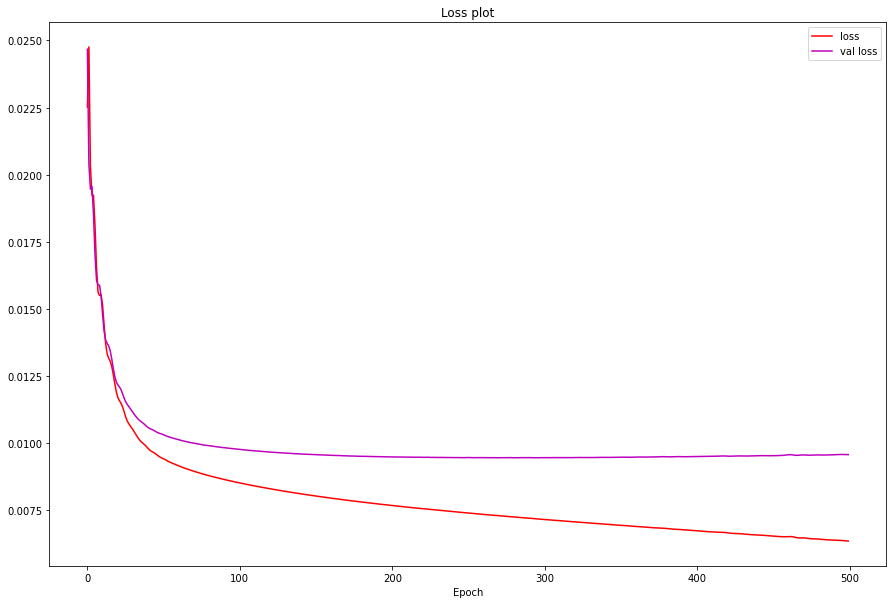

Training Loss before/after: 0.022518491372466087, 0.006360481958836317
Validation Loss before/after: 0.024672502651810646, 0.009578620083630085
Final loss: 0.006360481958836317
Time taken: 3.307384729385376
Model saved at model_data\VPMModel\Archi-3_[-2]-_epoch500_512_512_256.pt
4. Shift amt -1
Creating dataset for shift_amt = -1
Archi 0: X_train: (2880, 256), Y_train: (2880, 256), X_val: (1440, 256), Y_val: (1440, 256)
Archi 1: X_train: (2880, 296), Y_train: (2880, 256), X_val: (1440, 296), Y_val: (1440, 256)
Archi 2: X_train: (2880, 266), Y_train: (2880, 256), X_val: (1440, 266), Y_val: (1440, 256)
Archi 3: X_train: (2880, 512), Y_train: (2880, 256), X_val: (1440, 512), Y_val: (1440, 256)


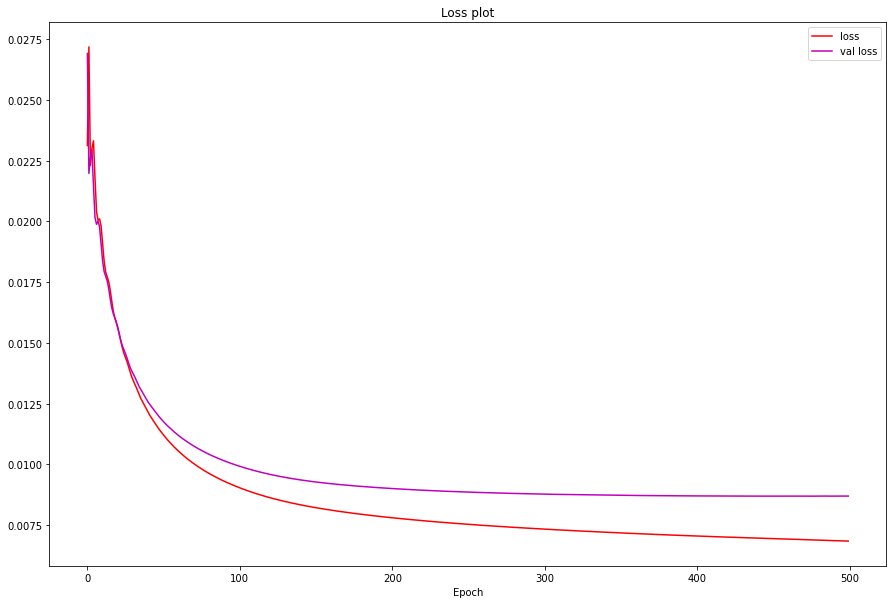

Training Loss before/after: 0.02312447875738144, 0.006836460903286934
Validation Loss before/after: 0.02691054157912731, 0.00868936162441969
Final loss: 0.006836460903286934
Time taken: 3.2116153240203857
Model saved at model_data\VPMModel\Archi-0_[-1]-_epoch500_256_256_256.pt


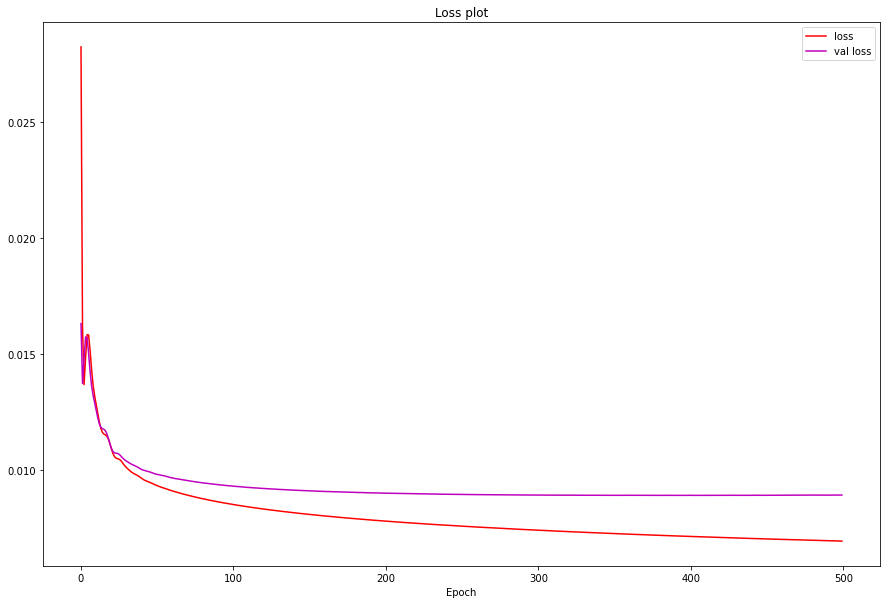

Training Loss before/after: 0.028222789987921715, 0.00691421190276742
Validation Loss before/after: 0.01629108190536499, 0.00890109408646822
Final loss: 0.00691421190276742
Time taken: 3.2009716033935547
Model saved at model_data\VPMModel\Archi-1_[-1]-_epoch500_296_296_256.pt


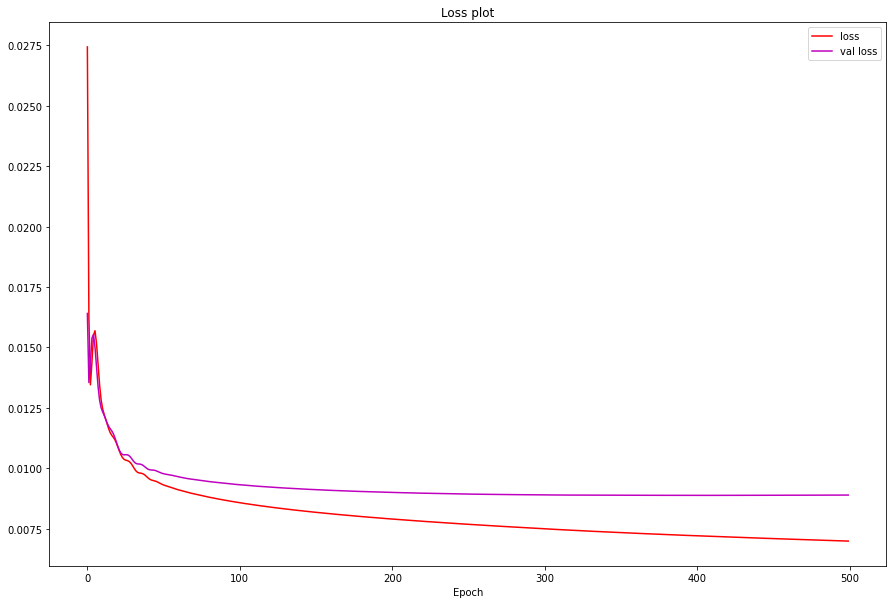

Training Loss before/after: 0.027432795614004135, 0.006980213802307844
Validation Loss before/after: 0.016402611508965492, 0.008885608054697514
Final loss: 0.006980213802307844
Time taken: 3.6116783618927
Model saved at model_data\VPMModel\Archi-2_[-1]-_epoch500_266_266_256.pt


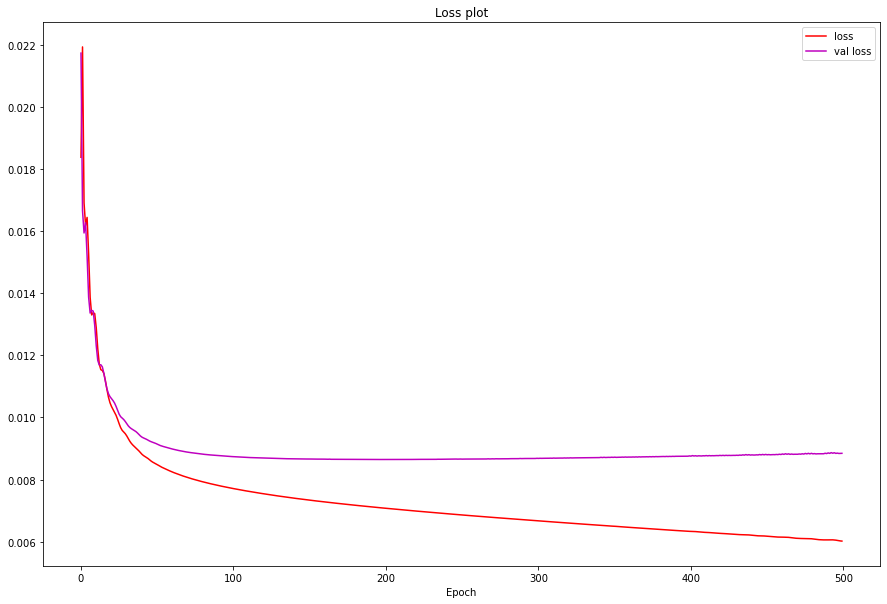

Training Loss before/after: 0.018386391922831535, 0.006015968509018421
Validation Loss before/after: 0.021743478253483772, 0.00884490180760622
Final loss: 0.006015968509018421
Time taken: 3.509162664413452
Model saved at model_data\VPMModel\Archi-3_[-1]-_epoch500_512_512_256.pt
5. Shift amt 0
Creating dataset for shift_amt = 0
Archi 0: X_train: (3072, 256), Y_train: (3072, 256), X_val: (1536, 256), Y_val: (1536, 256)
Archi 1: X_train: (3072, 296), Y_train: (3072, 256), X_val: (1536, 296), Y_val: (1536, 256)
Archi 2: X_train: (3072, 266), Y_train: (3072, 256), X_val: (1536, 266), Y_val: (1536, 256)
Archi 3: X_train: (3072, 512), Y_train: (3072, 256), X_val: (1536, 512), Y_val: (1536, 256)


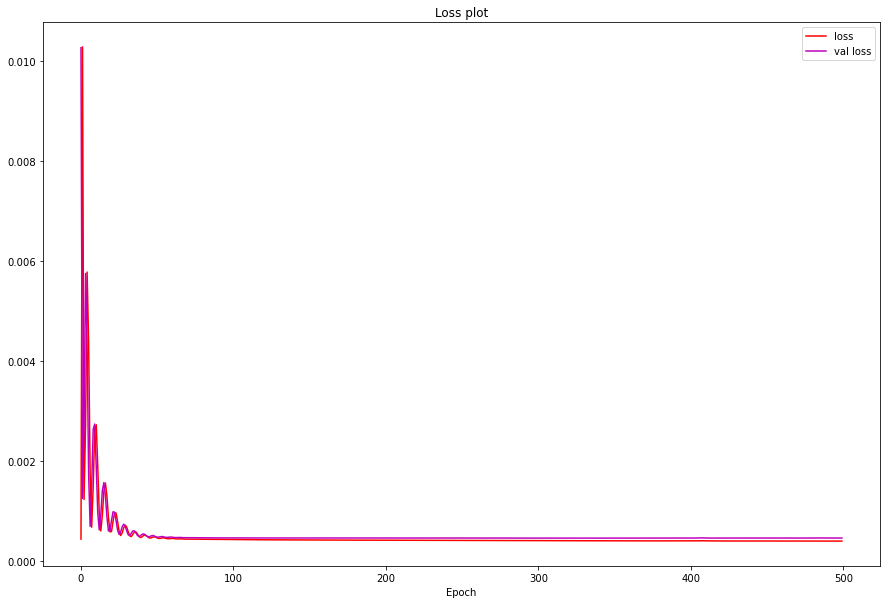

Training Loss before/after: 0.00044056499609723687, 0.0004009015392512083
Validation Loss before/after: 0.010256266221404076, 0.00046204373938962817
Final loss: 0.0004009015392512083
Time taken: 3.456334352493286
Model saved at model_data\VPMModel\Archi-0_[0]-_epoch500_256_256_256.pt


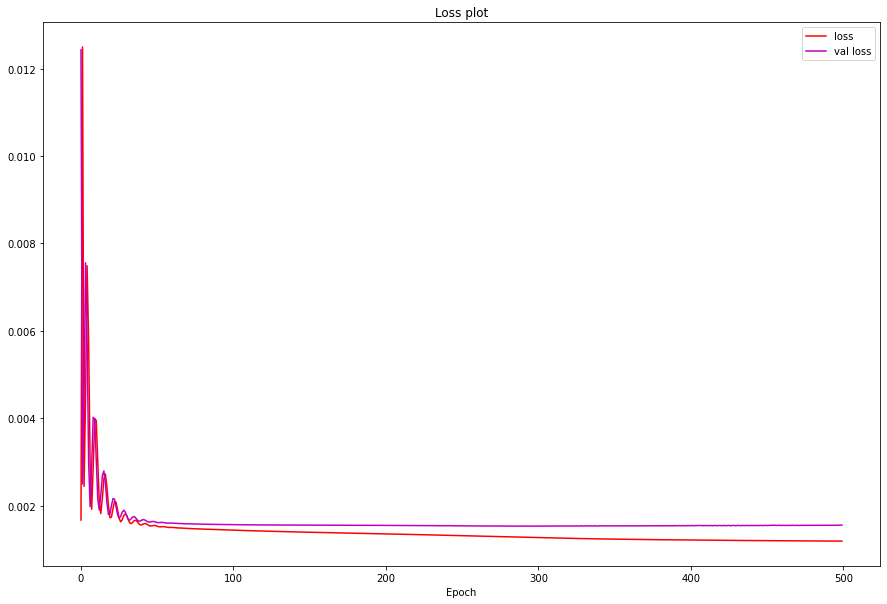

Training Loss before/after: 0.0016744770109653473, 0.0011935969814658165
Validation Loss before/after: 0.012429050169885159, 0.0015581382904201746
Final loss: 0.0011935969814658165
Time taken: 3.2069504261016846
Model saved at model_data\VPMModel\Archi-1_[0]-_epoch500_296_296_256.pt


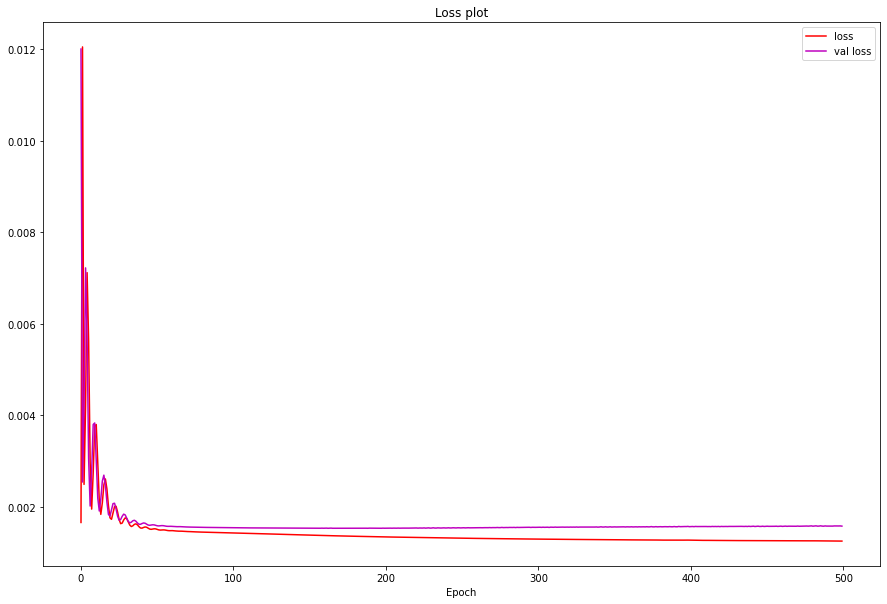

Training Loss before/after: 0.001661942107602954, 0.001255051582120359
Validation Loss before/after: 0.012005886062979698, 0.0015819566324353218
Final loss: 0.001255051582120359
Time taken: 3.509904146194458
Model saved at model_data\VPMModel\Archi-2_[0]-_epoch500_266_266_256.pt


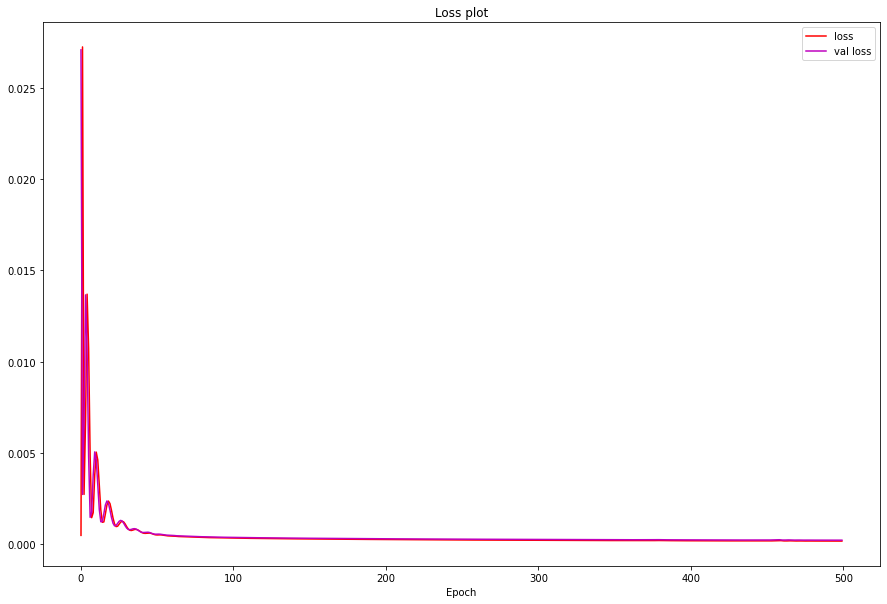

Training Loss before/after: 0.0004991259193047881, 0.00018614658620208502
Validation Loss before/after: 0.02707749232649803, 0.00023605884052813053
Final loss: 0.00018614658620208502
Time taken: 3.448935031890869
Model saved at model_data\VPMModel\Archi-3_[0]-_epoch500_512_512_256.pt
6. Shift amt 1
Creating dataset for shift_amt = 1
Archi 0: X_train: (2880, 256), Y_train: (2880, 256), X_val: (1440, 256), Y_val: (1440, 256)
Archi 1: X_train: (2880, 296), Y_train: (2880, 256), X_val: (1440, 296), Y_val: (1440, 256)
Archi 2: X_train: (2880, 266), Y_train: (2880, 256), X_val: (1440, 266), Y_val: (1440, 256)
Archi 3: X_train: (2880, 512), Y_train: (2880, 256), X_val: (1440, 512), Y_val: (1440, 256)


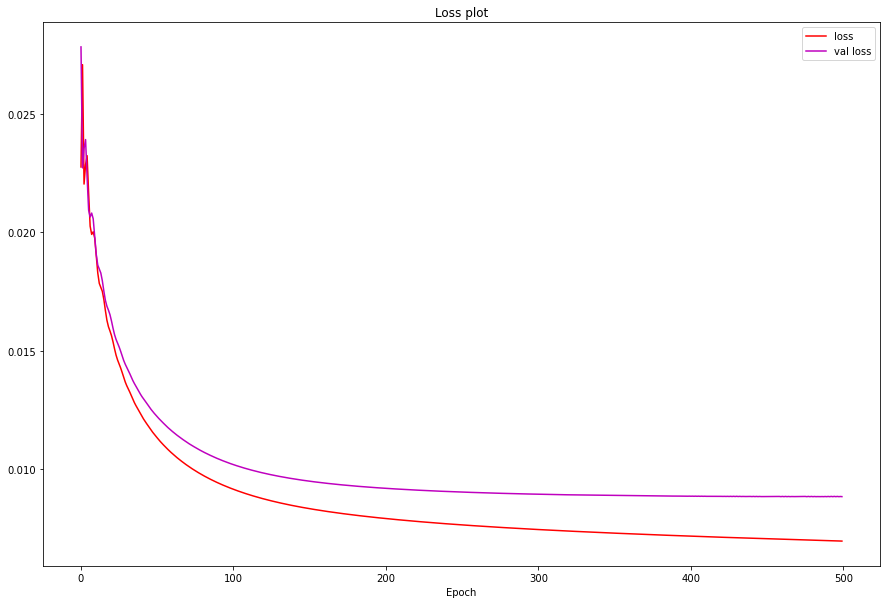

Training Loss before/after: 0.02276797965168953, 0.006954379845410585
Validation Loss before/after: 0.027842819690704346, 0.008833824656903744
Final loss: 0.006954379845410585
Time taken: 3.172917604446411
Model saved at model_data\VPMModel\Archi-0_[1]-_epoch500_256_256_256.pt


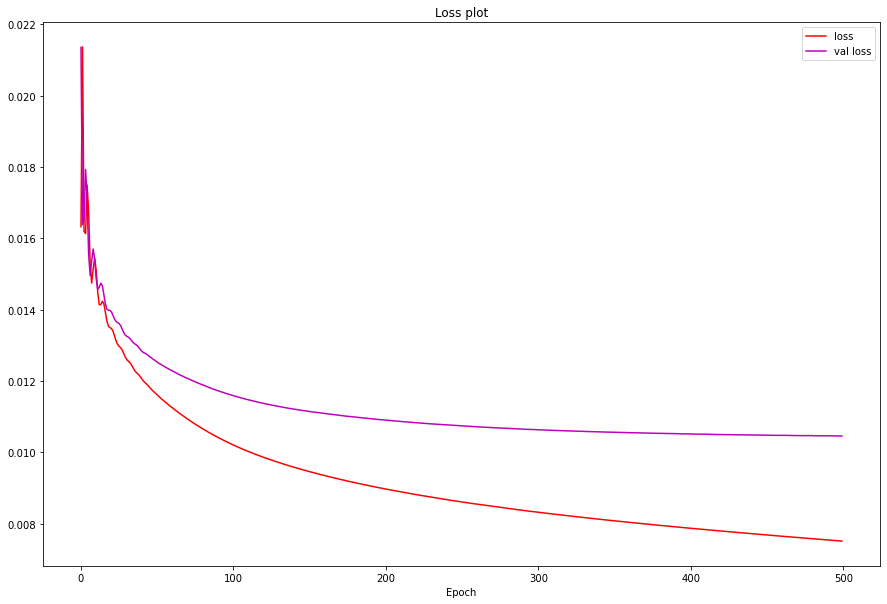

Training Loss before/after: 0.016325796023011208, 0.007512470241636038
Validation Loss before/after: 0.021351052448153496, 0.010457630269229412
Final loss: 0.007512470241636038
Time taken: 3.3477885723114014
Model saved at model_data\VPMModel\Archi-1_[1]-_epoch500_296_296_256.pt


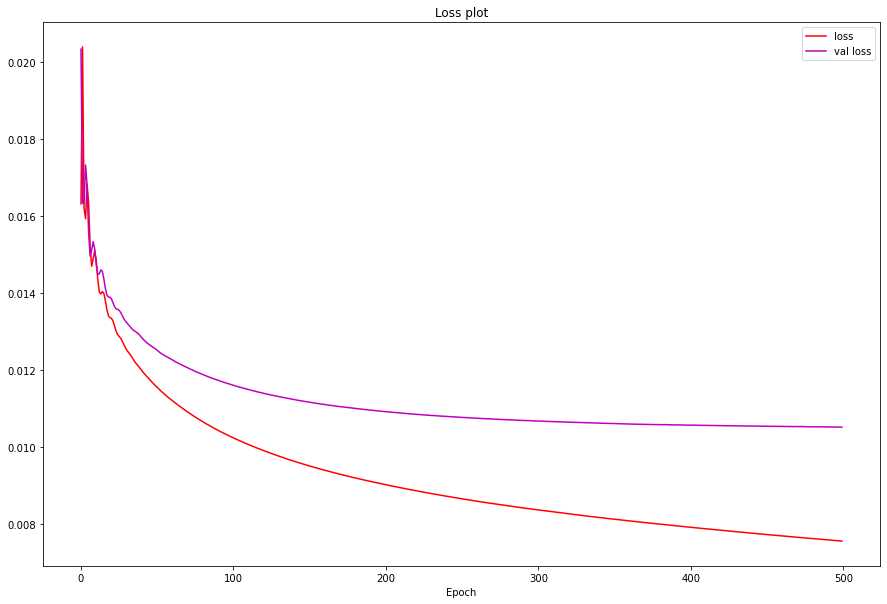

Training Loss before/after: 0.016312822699546814, 0.007556918077170849
Validation Loss before/after: 0.020332366228103638, 0.010514255613088608
Final loss: 0.007556918077170849
Time taken: 3.4212803840637207
Model saved at model_data\VPMModel\Archi-2_[1]-_epoch500_266_266_256.pt


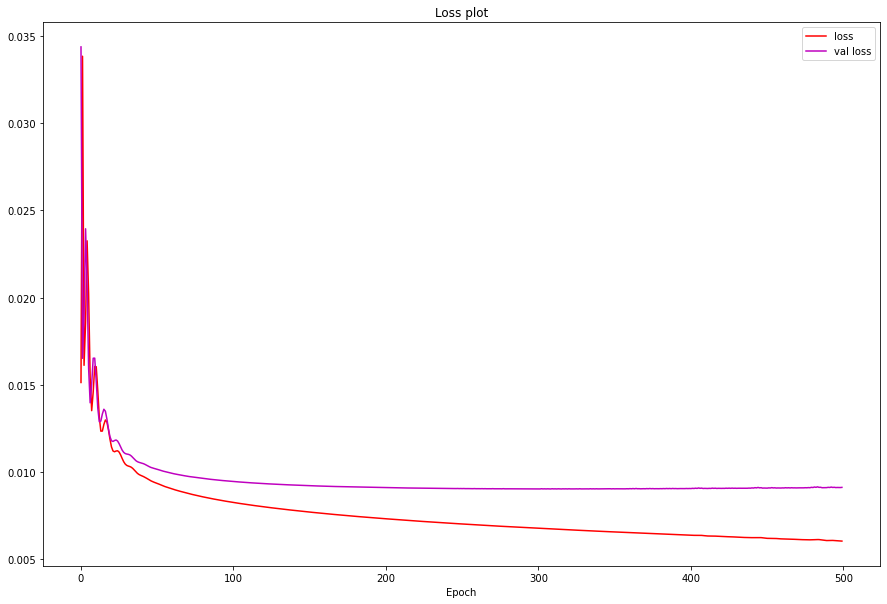

Training Loss before/after: 0.015134003944694996, 0.006050269119441509
Validation Loss before/after: 0.034352656453847885, 0.009126313962042332
Final loss: 0.006050269119441509
Time taken: 3.3206419944763184
Model saved at model_data\VPMModel\Archi-3_[1]-_epoch500_512_512_256.pt
7. Shift amt 2
Creating dataset for shift_amt = 2
Archi 0: X_train: (2688, 256), Y_train: (2688, 256), X_val: (1344, 256), Y_val: (1344, 256)
Archi 1: X_train: (2688, 296), Y_train: (2688, 256), X_val: (1344, 296), Y_val: (1344, 256)
Archi 2: X_train: (2688, 266), Y_train: (2688, 256), X_val: (1344, 266), Y_val: (1344, 256)
Archi 3: X_train: (2688, 512), Y_train: (2688, 256), X_val: (1344, 512), Y_val: (1344, 256)


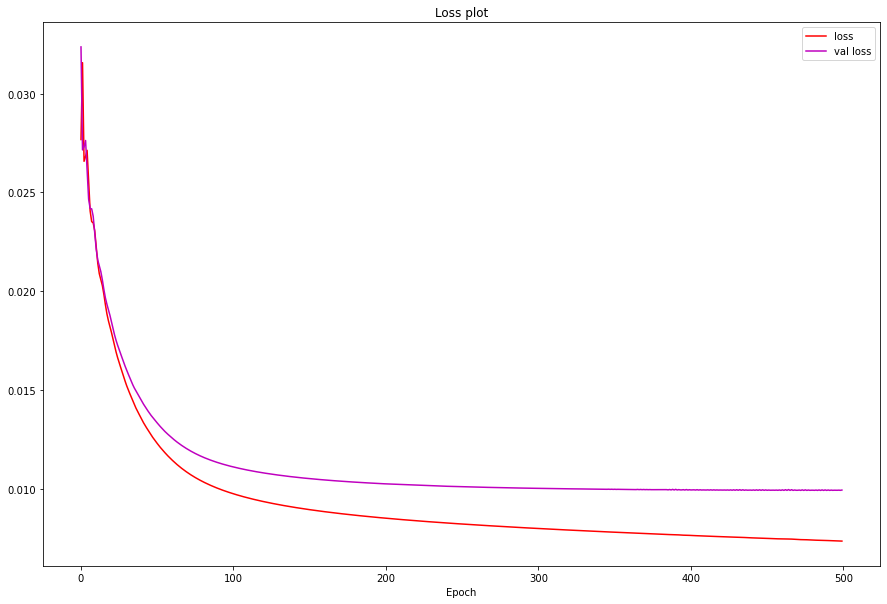

Training Loss before/after: 0.02767609804868698, 0.007360156159847975
Validation Loss before/after: 0.03236251324415207, 0.00994215440005064
Final loss: 0.007360156159847975
Time taken: 3.0336477756500244
Model saved at model_data\VPMModel\Archi-0_[2]-_epoch500_256_256_256.pt


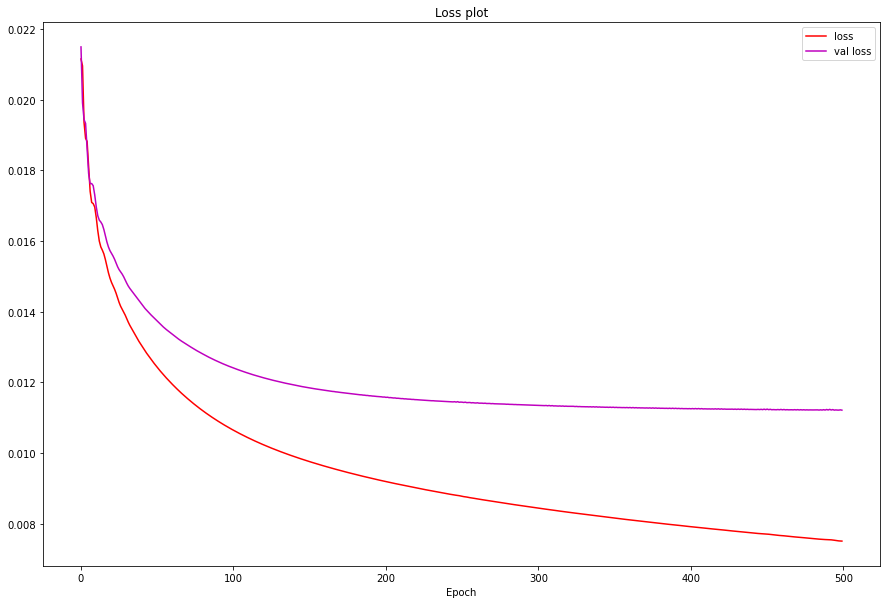

Training Loss before/after: 0.021151622757315636, 0.007512716576457024
Validation Loss before/after: 0.021492850035429, 0.011216630227863789
Final loss: 0.007512716576457024
Time taken: 3.3627851009368896
Model saved at model_data\VPMModel\Archi-1_[2]-_epoch500_296_296_256.pt


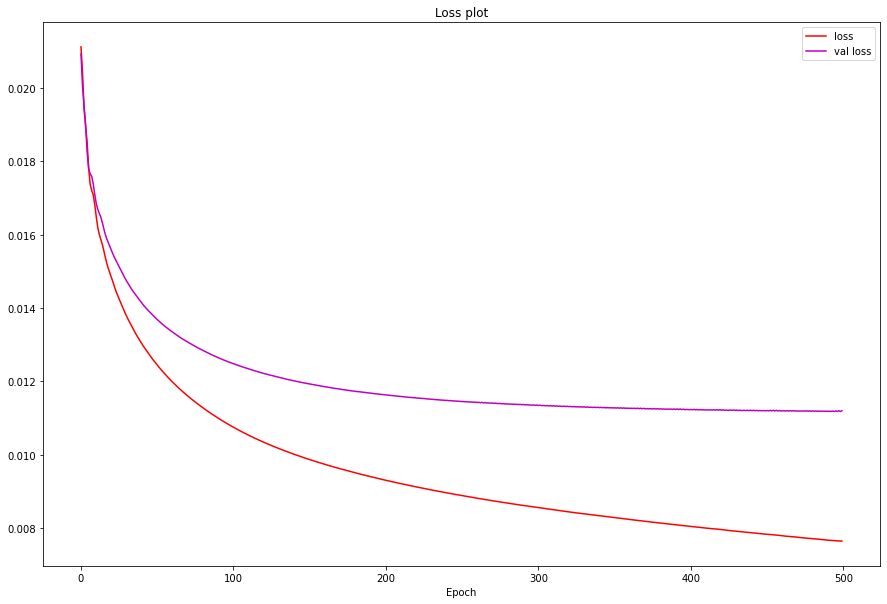

Training Loss before/after: 0.021125469356775284, 0.007643567863851786
Validation Loss before/after: 0.020933233201503754, 0.011199362576007843
Final loss: 0.007643567863851786
Time taken: 3.4519569873809814
Model saved at model_data\VPMModel\Archi-2_[2]-_epoch500_266_266_256.pt


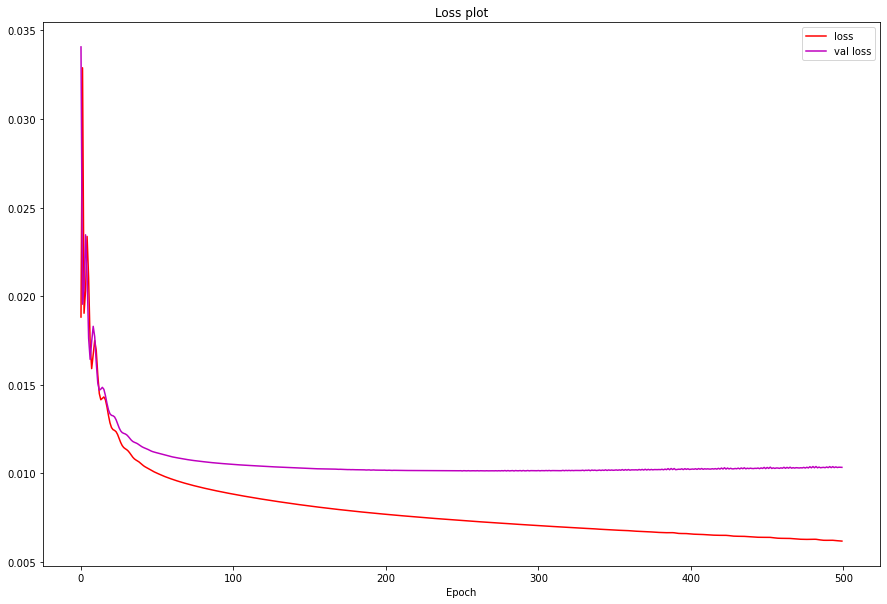

Training Loss before/after: 0.01881803199648857, 0.006173241883516312
Validation Loss before/after: 0.034066181629896164, 0.010335578583180904
Final loss: 0.006173241883516312
Time taken: 3.4588358402252197
Model saved at model_data\VPMModel\Archi-3_[2]-_epoch500_512_512_256.pt
8. Shift amt 3
Creating dataset for shift_amt = 3
Archi 0: X_train: (2496, 256), Y_train: (2496, 256), X_val: (1248, 256), Y_val: (1248, 256)
Archi 1: X_train: (2496, 296), Y_train: (2496, 256), X_val: (1248, 296), Y_val: (1248, 256)
Archi 2: X_train: (2496, 266), Y_train: (2496, 256), X_val: (1248, 266), Y_val: (1248, 256)
Archi 3: X_train: (2496, 512), Y_train: (2496, 256), X_val: (1248, 512), Y_val: (1248, 256)


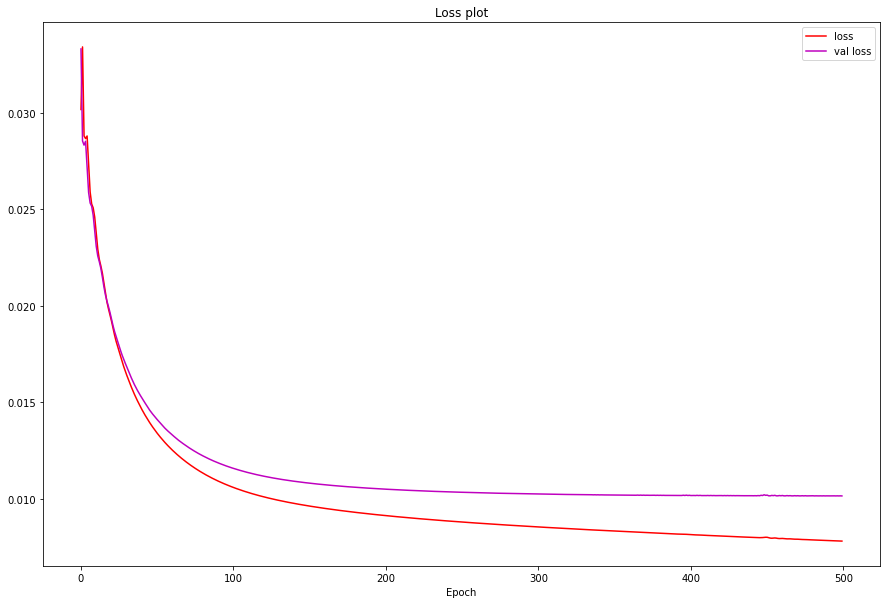

Training Loss before/after: 0.030158236622810364, 0.007821816951036453
Validation Loss before/after: 0.03329282999038696, 0.010159149765968323
Final loss: 0.007821816951036453
Time taken: 3.1913976669311523
Model saved at model_data\VPMModel\Archi-0_[3]-_epoch500_256_256_256.pt


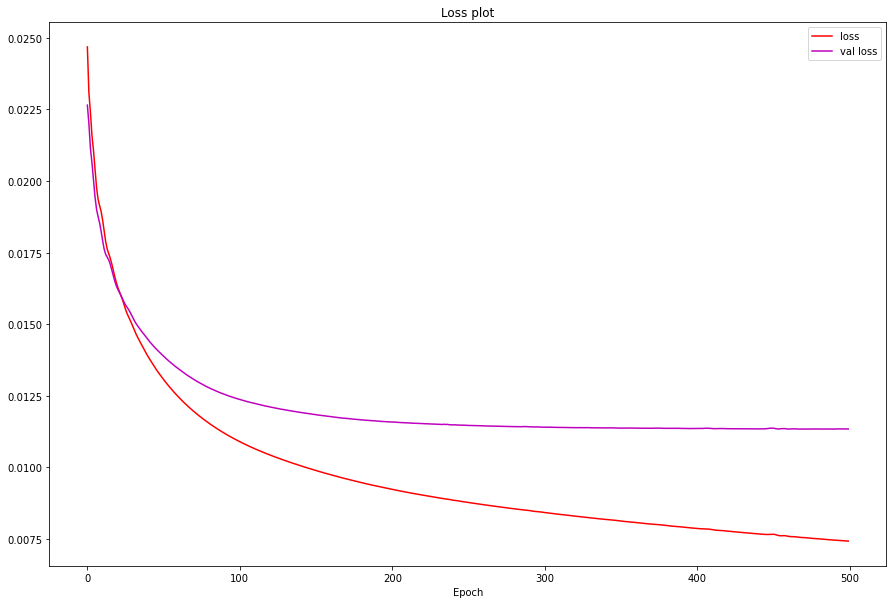

Training Loss before/after: 0.02468138188123703, 0.007428276352584362
Validation Loss before/after: 0.022649506106972694, 0.011343162506818771
Final loss: 0.007428276352584362
Time taken: 3.3933753967285156
Model saved at model_data\VPMModel\Archi-1_[3]-_epoch500_296_296_256.pt


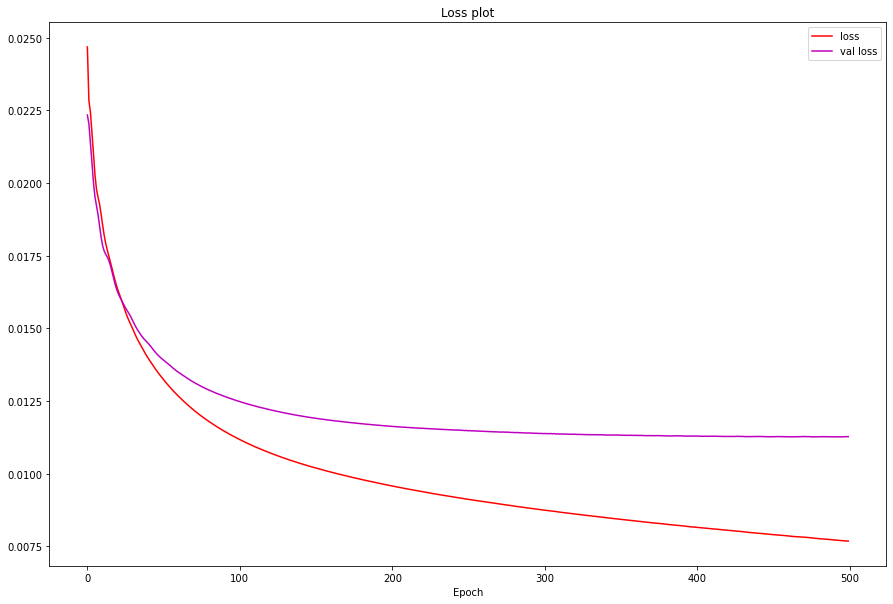

Training Loss before/after: 0.02468244731426239, 0.0076834699138998985
Validation Loss before/after: 0.022340133786201477, 0.011277295649051666
Final loss: 0.0076834699138998985
Time taken: 3.443920373916626
Model saved at model_data\VPMModel\Archi-2_[3]-_epoch500_266_266_256.pt


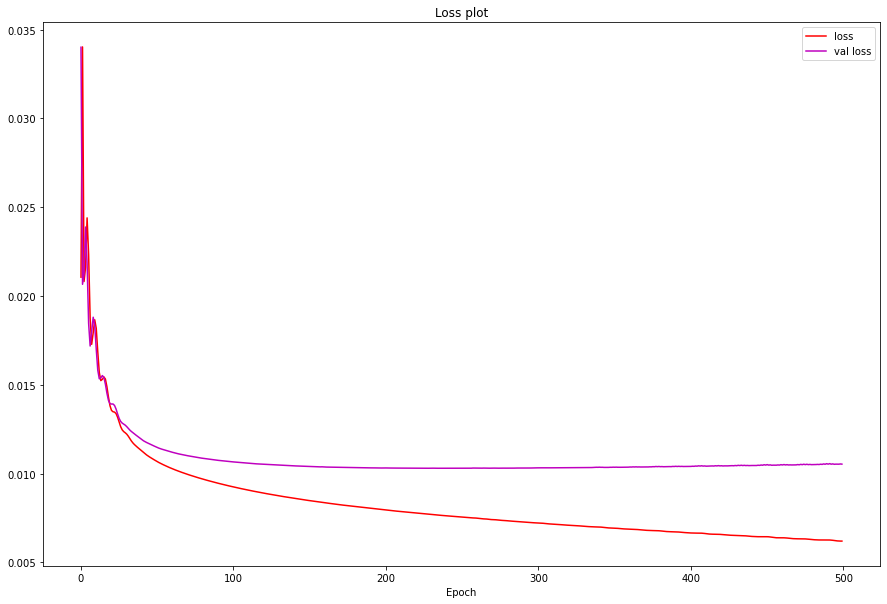

Training Loss before/after: 0.02106342650949955, 0.006202831398695707
Validation Loss before/after: 0.034011360257864, 0.010536320507526398
Final loss: 0.006202831398695707
Time taken: 3.396890163421631
Model saved at model_data\VPMModel\Archi-3_[3]-_epoch500_512_512_256.pt
9. Shift amt 4
Creating dataset for shift_amt = 4
Archi 0: X_train: (2304, 256), Y_train: (2304, 256), X_val: (1152, 256), Y_val: (1152, 256)
Archi 1: X_train: (2304, 296), Y_train: (2304, 256), X_val: (1152, 296), Y_val: (1152, 256)
Archi 2: X_train: (2304, 266), Y_train: (2304, 256), X_val: (1152, 266), Y_val: (1152, 256)
Archi 3: X_train: (2304, 512), Y_train: (2304, 256), X_val: (1152, 512), Y_val: (1152, 256)


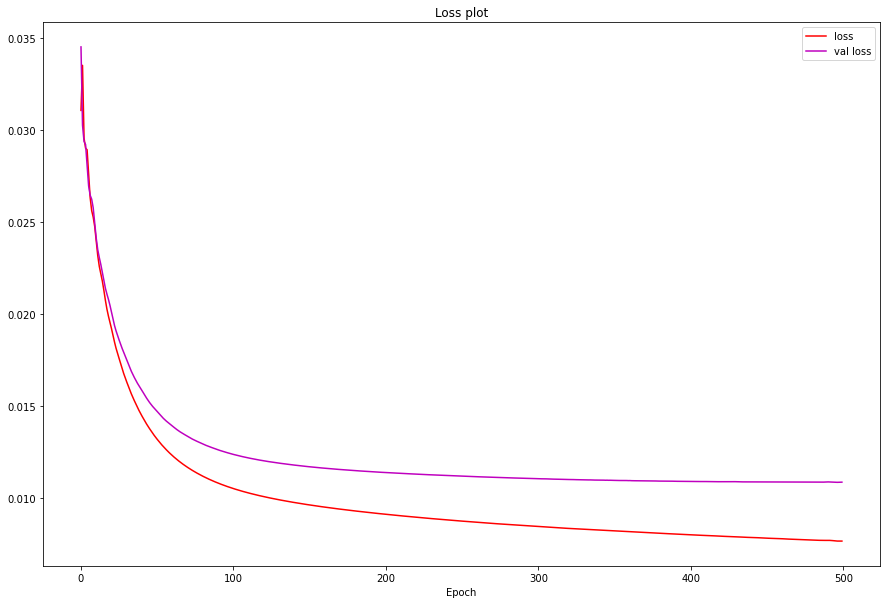

Training Loss before/after: 0.031046804040670395, 0.0076353708282113075
Validation Loss before/after: 0.03449787199497223, 0.010838109999895096
Final loss: 0.0076353708282113075
Time taken: 3.124305486679077
Model saved at model_data\VPMModel\Archi-0_[4]-_epoch500_256_256_256.pt


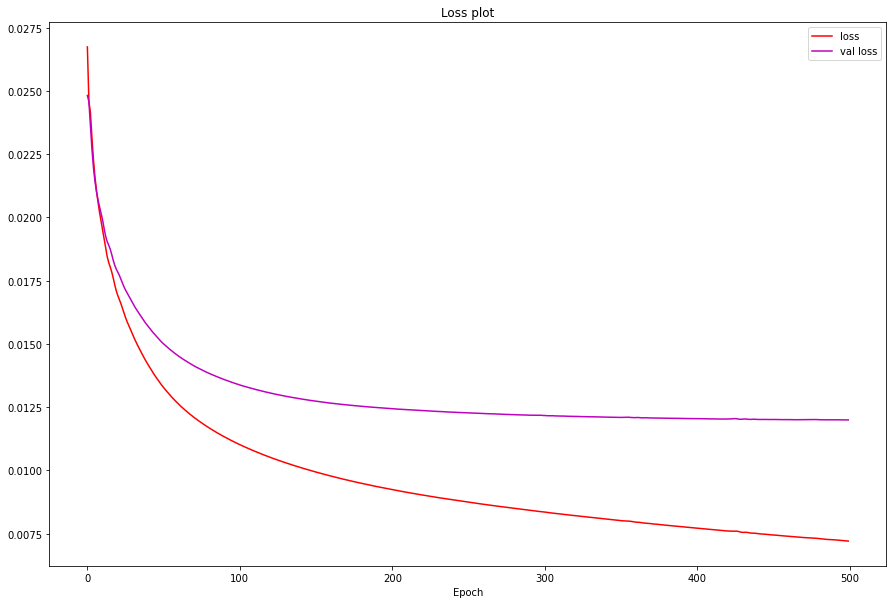

Training Loss before/after: 0.026738617569208145, 0.007209023926407099
Validation Loss before/after: 0.02481885254383087, 0.011998114176094532
Final loss: 0.007209023926407099
Time taken: 3.193866729736328
Model saved at model_data\VPMModel\Archi-1_[4]-_epoch500_296_296_256.pt


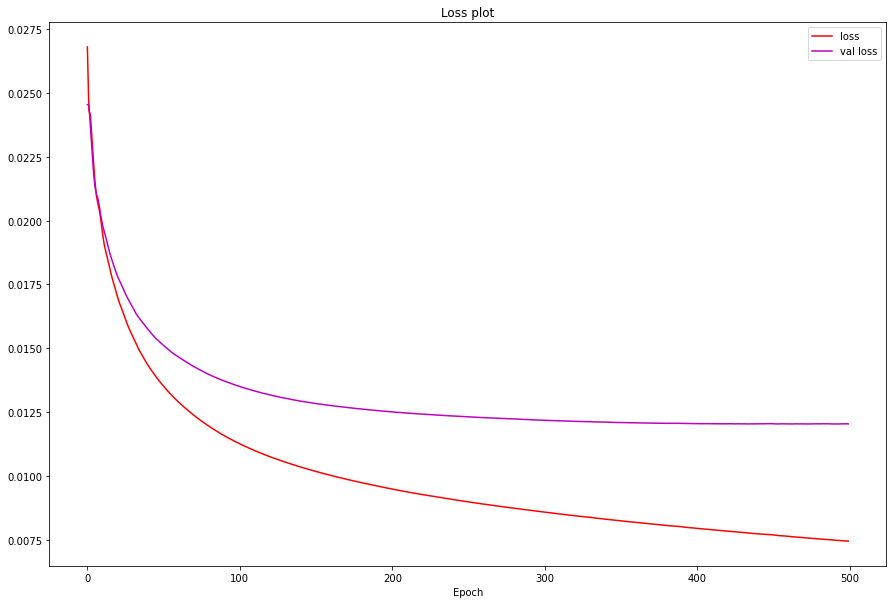

Training Loss before/after: 0.026812167838215828, 0.007442657370120287
Validation Loss before/after: 0.024549288675189018, 0.012034766376018524
Final loss: 0.007442657370120287
Time taken: 3.243175506591797
Model saved at model_data\VPMModel\Archi-2_[4]-_epoch500_266_266_256.pt


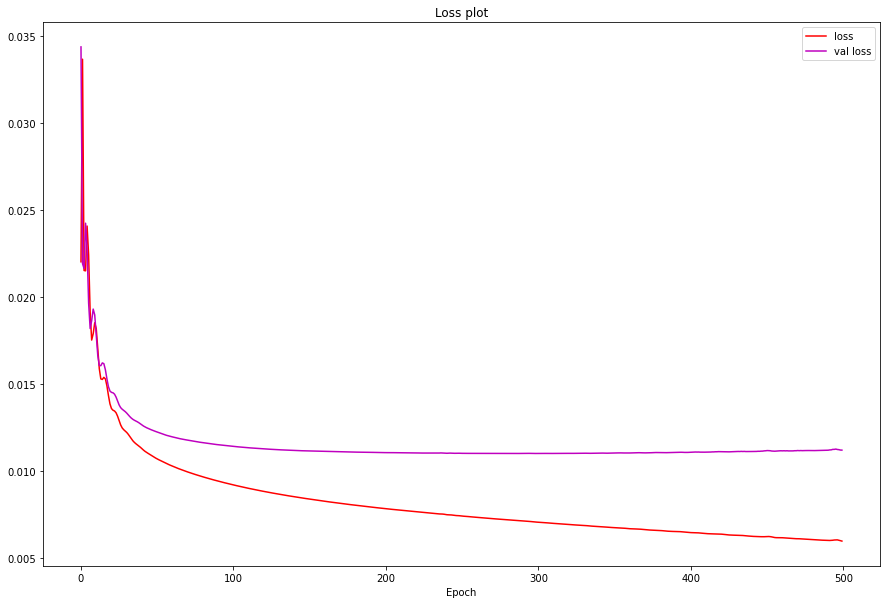

Training Loss before/after: 0.02202821709215641, 0.005992739461362362
Validation Loss before/after: 0.03436717018485069, 0.011215870268642902
Final loss: 0.005992739461362362
Time taken: 3.1825084686279297
Model saved at model_data\VPMModel\Archi-3_[4]-_epoch500_512_512_256.pt
10. Shift amt 5
Creating dataset for shift_amt = 5
Archi 0: X_train: (2112, 256), Y_train: (2112, 256), X_val: (1056, 256), Y_val: (1056, 256)
Archi 1: X_train: (2112, 296), Y_train: (2112, 256), X_val: (1056, 296), Y_val: (1056, 256)
Archi 2: X_train: (2112, 266), Y_train: (2112, 256), X_val: (1056, 266), Y_val: (1056, 256)
Archi 3: X_train: (2112, 512), Y_train: (2112, 256), X_val: (1056, 512), Y_val: (1056, 256)


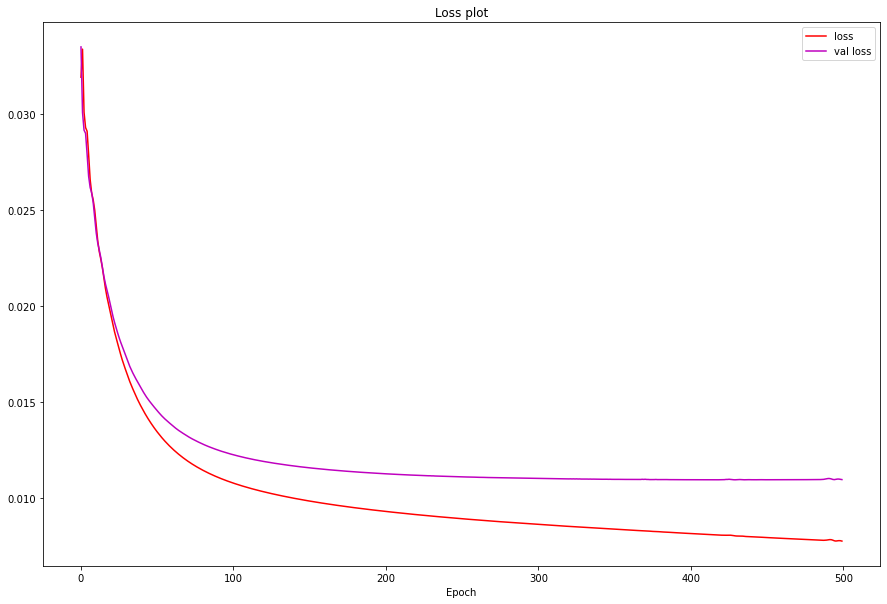

Training Loss before/after: 0.03190651163458824, 0.007780134677886963
Validation Loss before/after: 0.03348248451948166, 0.01097938697785139
Final loss: 0.007780134677886963
Time taken: 3.14048433303833
Model saved at model_data\VPMModel\Archi-0_[5]-_epoch500_256_256_256.pt


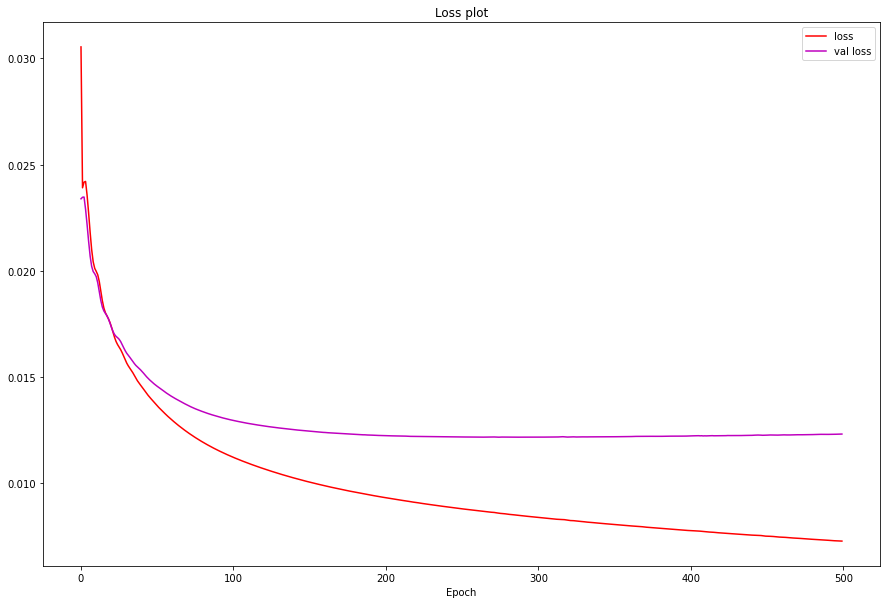

Training Loss before/after: 0.03054429590702057, 0.007255834527313709
Validation Loss before/after: 0.023385977372527122, 0.012299939058721066
Final loss: 0.007255834527313709
Time taken: 3.4464590549468994
Model saved at model_data\VPMModel\Archi-1_[5]-_epoch500_296_296_256.pt


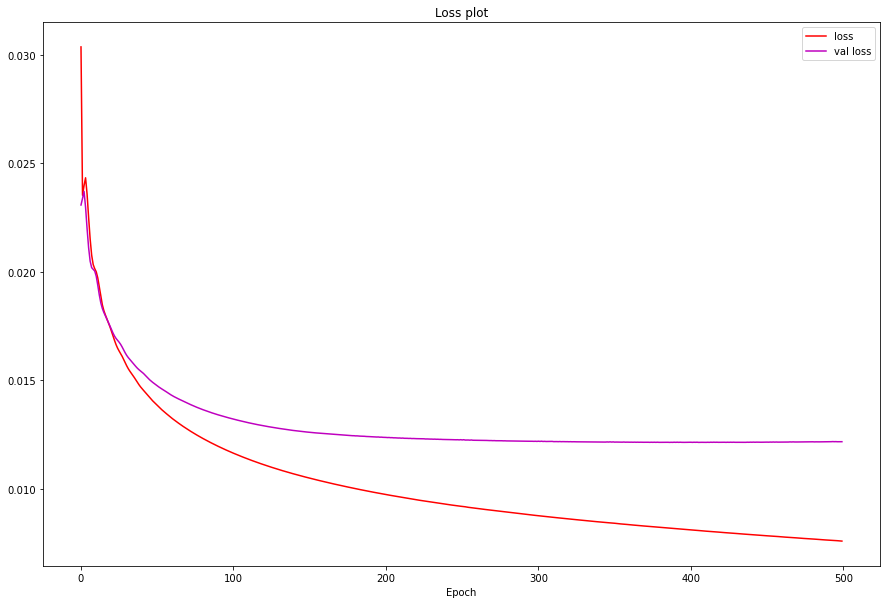

Training Loss before/after: 0.030354255810379982, 0.007597623858600855
Validation Loss before/after: 0.023073837161064148, 0.012174421921372414
Final loss: 0.007597623858600855
Time taken: 3.246133804321289
Model saved at model_data\VPMModel\Archi-2_[5]-_epoch500_266_266_256.pt


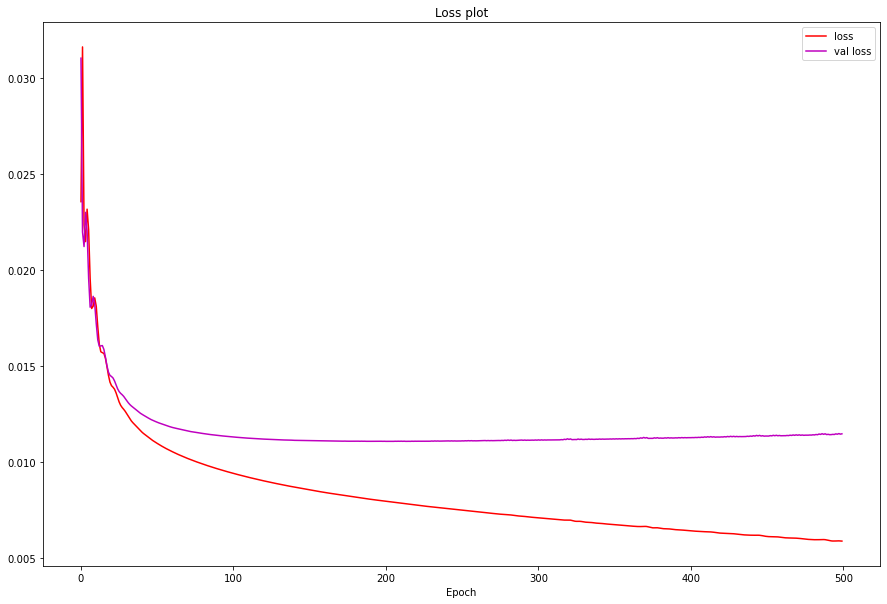

Training Loss before/after: 0.023572539910674095, 0.00586525397375226
Validation Loss before/after: 0.03105970285832882, 0.01146208867430687
Final loss: 0.00586525397375226
Time taken: 3.5135486125946045
Model saved at model_data\VPMModel\Archi-3_[5]-_epoch500_512_512_256.pt


In [69]:
# Define loss 
loss_fn = nn.MSELoss()

# Data for training the NNs
n_inputs = [ 256, 296, 266, 512 ] 
n_hids =  [ 256, 296, 266, 512 ]
overlap = 0.5; n_mels = 256; lr = 1e-3; n_epochs = 500; 
# Transfer learning - we take the model from the autoencoder stage
model_paths = [
    "Archi-0_Identity-Mels-to-Mels_epoch5000_256_256_256.pt",
    "Archi-1_Identity-Mels-to-Mels_epoch5000_296_296_256.pt",
    "Archi-2_Identity-Mels-to-Mels_epoch5000_266_266_256.pt",
    "Archi-3_Identity-Mels-to-Mels_epoch5000_512_512_256.pt"
]
file_paths = [
    "Archi-0_ModelInfo.txt",
    "Archi-1_ModelInfo.txt",
    "Archi-2_ModelInfo.txt",
    "Archi-3_ModelInfo.txt"
]
# Files to be written to
fs = []
writers = []
for archi in range(4):
    fs.append(open(os.path.join("model_data", "VPMModel", file_paths[archi]), 'w', newline=''))
    writers.append(csv.writer(fs[archi]))
    writers[archi].writerow(["Index", "Pitch Shift Amt", "Max Mels", "Path"])

# Main NN generation loop
pitch_shift_amts = [ -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
for idx, pitch_shift_amt in enumerate(pitch_shift_amts):
    print("{}. Shift amt {}".format(idx, pitch_shift_amt))
    X_trains, Y_trains, X_vals, Y_vals, list_of_test_idx, max_pitched_mels, all_pitched_mels = create_training_dataset(n_ffts, overlap, n_mels, pitch_shift_amt, sparsity_factor = 4)

    for archi in range(4):
        X_train, Y_train, X_val, Y_val = map(torch.Tensor, (X_trains[archi], Y_trains[archi], X_vals[archi], Y_vals[archi]))
        X_train.float(); Y_train.float(); X_val.float(); Y_val.float();

        model_path = os.path.join("model_data", "VPMModel", model_paths[archi])
        model = BaseFFN(n_input=n_inputs[archi], n_hid=n_hids[archi], n_output=n_mels)
        model.load_state_dict(torch.load(model_path))
        # CPU Option
        # model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        model.eval()

         # Use GPU if possible (will run on CPU otherwise)
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        # Move inputs to GPU (if possible)
        X_train = X_train.to(device)
        Y_train = Y_train.to(device)
        X_val = X_val.to(device)
        Y_val = Y_val.to(device)

        # Move the network to GPU (if possible)
        model.to(device) 
        # Define optimizer 
        # opt = optim.SGD(model.parameters(), lr=lr)
        opt = optim.Adam(model.parameters(), lr=lr)

        # Fit the model
        tic = time.time()
        train_loss, val_loss = model.train_func(X_train, Y_train, X_val, Y_val, model, opt,
                                loss_fn, epochs=n_epochs, print_graph=True)
        toc = time.time()
        print('Final loss: {}\nTime taken: {}'.format(train_loss, toc - tic))    

        n_output = n_mels
        
        currModelPath = "Archi-{}_[{}]-_epoch{}_{}_{}_{}.pt".format(archi, pitch_shift_amt, n_epochs, n_inputs[archi], n_hids[archi], n_mels)
        model_path = os.path.join("model_data", "VPMModel", currModelPath)
        torch.save(model.state_dict(), model_path)
        print("Model saved at {}".format(model_path))    

        writers[archi].writerow([idx, pitch_shift_amt, max_pitched_mels, currModelPath])

# Close csv writers
for archi in range(4):
    fs[archi].close()


# Using the Pitch Shifter
This is a basic example of how to use the pitch shifter.

In [27]:
pIdx = 5; pid = 0;
vIdxs = [5]
shiftAmts = [4]
for vIdx in vIdxs:
    for shiftAmt in shiftAmts:
        # Example of loading a specific file
        filename = [ "scale.wav" ]
        wavform = load_wav_files("",filename)[0]
        
        print("Shifting {} by {}".format(filename[0], shiftAmt))
        decodedShift, pureShift = PitchShift(wavform, shiftAmt, )
        
        sio.wavfile.write(os.path.join("many_expts", '{}_Decoded_[{}].wav'.format(filename, shiftAmt)), 44100, decodedShift)
        sio.wavfile.write(os.path.join("many_expts", '{}_PureShift_[{}].wav'.format(filename, shiftAmt)), 44100, pureShift)

Please resample to 44100Hz for better results, but continuing regardless...
Shifting scale.wav by 4


ValueError: too many values to unpack (expected 2)

Example of doing a batch

In [17]:
# pIdx = 6; pid = 0;
# vIdxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# shiftAmts = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]

pIdx = 7; pid = 0;
vIdxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
shiftAmts = [-5, -3, 3, 5]
for vIdx in vIdxs:
    shiftAmt = shiftAmts[int(np.random.random() * 4)]
#     for shiftAmt in shiftAmts:
    wavIdx = flat_ref_idx(vIdx, pIdx, pid)
    filename = [ flat_data_ref_list[wavIdx] ]
    wavform = load_wav_files(os.path.join("Data", "dataset"), filename)[0]

    print("Shifting {} by {}".format(filename[0], shiftAmt))
    for archi in range(4):
        PitchShiftss = [ PitchShift0, PitchShift1, PitchShift2, PitchShift3 ]
        PitchShift=  PitchShiftss[archi]
        decodedShift, pureShift = PitchShift(wavform, shiftAmt)

        sio.wavfile.write(os.path.join("many_expts", '{}_Archi-{}_Decoded_[{}].wav'.format(filename, archi, shiftAmt)), 44100, decodedShift)
        if (archi == 0):
            sio.wavfile.write(os.path.join("many_expts", '{}_PureShift_[{}].wav'.format(filename, shiftAmt)), 44100, pureShift)        

Shifting 0_0-bed_7-E3.wav by -5
Shifting 0_1-bird_7-E3.wav by -5
Shifting 0_2-boat_7-E3.wav by -3
Shifting 0_3-book_7-E3.wav by -5
Shifting 0_4-cat_7-E3.wav by -5
Shifting 0_5-dog_7-E3.wav by -3
Shifting 0_6-feet_7-E3.wav by -5
Shifting 0_7-law_7-E3.wav by -5
Shifting 0_8-moo_7-E3.wav by 3
Shifting 0_9-nut_7-E3.wav by 3
Shifting 0_10-pig_7-E3.wav by 5
Shifting 0_11-say_7-E3.wav by -3
